In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import itertools
from tqdm import tqdm
import datetime
from datetime import timedelta
from datetime import datetime

# SARIMA model
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Seq2seq
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

In [3]:
df_siberia = pd.concat([pd.read_parquet(f'data/tec_{i}.parquet.gzip') for i in range(2001, 2017)])
df_siberia = df_siberia [(df_siberia['gdlat'] >= 56.0) & (df_siberia['gdlat'] <= 58.0) & (df_siberia['glon'] >= 136.0) & (df_siberia['glon'] <= 140.0)][['datetime', 'gdlat', 'glon', 'tec']]
df_siberia

,datetime,gdlat,glon,tec
52995,2001-01-01 01:12:30,56.0,140.0,20.0
56835,2001-01-01 01:17:30,56.0,139.0,19.9
56836,2001-01-01 01:17:30,56.0,140.0,19.6
60730,2001-01-01 01:22:30,56.0,139.0,21.5
60761,2001-01-01 01:22:30,57.0,139.0,25.8
...,...,...,...,...
12439042,2016-11-27 06:22:30,58.0,139.0,7.4
12450679,2016-11-27 06:27:30,57.0,139.0,7.4
12450680,2016-11-27 06:27:30,57.0,140.0,7.4
12462724,2016-11-27 06:32:30,56.0,140.0,7.4


In [4]:
df_dst = pd.read_csv('dst/dst2001_2017.csv')[['ut1_unix', 'ut2_unix', 'dst']]
df_dst['time'] = 0.5*(df_dst['ut1_unix'] + df_dst['ut2_unix'])
df_dst['datetime'] = pd.to_datetime(df_dst['time'], unit='s')
df_dst = df_dst.set_index('datetime').drop(['ut1_unix', 'ut2_unix', 'time'], axis=1)
df_dst['storm'] = df_dst['dst'] < -50
df_dst['major_storm'] = df_dst['dst'] < -100
has_major_peak = set()
current_storm_no = 1
previous_storm = False
for ix, row in tqdm(df_dst.iterrows()):
    if not row['storm']:
        if not previous_storm:
            continue
        else:
            previous_storm = False
            current_storm_no += 1     
            continue
    else:
        if previous_storm:
            df_dst.loc[ix, 'storm_no'] = current_storm_no
            if row['major_storm']:
                has_major_peak.add(current_storm_no)
                continue           
        else:
            previous_storm = True
            df_dst.loc[ix, 'storm_no'] = current_storm_no
            if row['major_storm']:
                has_major_peak.add(current_storm_no)
                continue
storms = []
for i in sorted(list(has_major_peak)):
    storm = df_dst [df_dst['storm_no'] == i]['dst']
    storms.append((storm.index[0].floor('2h'), storm.index[-1].ceil('2h')))
storms = [storm for storm in storms if (storm[0] >= datetime(2003, 1, 1))]
storms

140396it [00:05, 26763.15it/s]


[(Timestamp('2003-05-29 20:00:00'), Timestamp('2003-05-30 18:00:00')),
 (Timestamp('2003-06-18 04:00:00'), Timestamp('2003-06-19 04:00:00')),
 (Timestamp('2003-07-11 16:00:00'), Timestamp('2003-07-12 18:00:00')),
 (Timestamp('2003-08-18 04:00:00'), Timestamp('2003-08-19 12:00:00')),
 (Timestamp('2003-10-29 06:00:00'), Timestamp('2003-11-01 08:00:00')),
 (Timestamp('2003-11-20 12:00:00'), Timestamp('2003-11-22 10:00:00')),
 (Timestamp('2004-01-22 12:00:00'), Timestamp('2004-01-23 12:00:00')),
 (Timestamp('2004-04-03 18:00:00'), Timestamp('2004-04-04 08:00:00')),
 (Timestamp('2004-07-25 00:00:00'), Timestamp('2004-07-26 16:00:00')),
 (Timestamp('2004-07-27 00:00:00'), Timestamp('2004-07-29 18:00:00')),
 (Timestamp('2004-08-30 14:00:00'), Timestamp('2004-08-31 16:00:00')),
 (Timestamp('2004-11-07 20:00:00'), Timestamp('2004-11-11 22:00:00')),
 (Timestamp('2005-01-18 00:00:00'), Timestamp('2005-01-18 18:00:00')),
 (Timestamp('2005-05-08 12:00:00'), Timestamp('2005-05-09 10:00:00')),
 (Time

## Manipulation des données

In [5]:
def equilibrate_regions(df):
    duplicate = np.max(pd.crosstab(df['gdlat'], df['glon'])) // pd.crosstab(df['gdlat'], df['glon']) - 1
    sample = np.max(pd.crosstab(df['gdlat'], df['glon'])) % pd.crosstab(df['gdlat'], df['glon'])
    for gdlat in duplicate.index:
        for glon in duplicate.columns:
            # Duplicate
            df_lat_lon = df[ (df['gdlat'] == gdlat) & (df['glon'] == glon) ].reset_index(drop=True)
            add = [df_lat_lon]*duplicate.loc[gdlat, glon]
            # Sample
            sampled_indices = np.random.choice(df_lat_lon.index, size=sample.loc[gdlat, glon], replace=False)
            add.append(df_lat_lon.loc[sampled_indices, :])
            # Add new rows
            if add:
                add = pd.concat(add)
                df = pd.concat([df, add]).reset_index(drop=True)
    return df.sort_values(by='datetime').reset_index(drop=True)

In [6]:
def average_by_2hourly_bin(df, datetime_col, measure_col):
    """
    Average values within 2-hour bins.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing datetime and measure columns
    datetime_col : str
        Name of the datetime column
    measure_col : str
        Name of the measure column
    
    Returns:
    --------
    pandas.DataFrame
        Dataframe with 2-hourly timestamps and averaged values
    """
    df = df.copy()
    
    # Create regular 2-hourly time index
    start_time = df[datetime_col].min().floor('2h')
    end_time = df[datetime_col].max().ceil('2h')
    two_hourly_index = pd.date_range(start=start_time, end=end_time, freq='2h')
    
    # Bin data into 2-hour intervals and calculate mean
    df[datetime_col] = pd.to_datetime(df[datetime_col]).dt.floor('2h')
    result = df.groupby(datetime_col)[measure_col].mean().reindex(two_hourly_index)
    
    # Convert to dataframe
    result_df = result.reset_index()
    result_df.columns = [datetime_col, measure_col]
    
    return result_df

In [7]:
def create_trajectory_matrix(time_series, window):
    """
    Create trajectory matrix from time series using sliding window.
    
    Args:
        time_series (array-like): Input time series
        window (int): Window size
        
    Returns:
        np.ndarray: Trajectory matrix
    """
    n = len(time_series)
    k = n - window + 1
    matrix = np.zeros((k, window))
    
    for i in range(k):
        matrix[i, :] = time_series[i:i + window]
        
    return matrix

In [8]:
def low_rank_interpolate(X, W, K, max_iter=100, tol=1e-6):
    """
    Interpolate missing values in trajectory matrix using low rank approximation.
    
    Args:
        X (np.ndarray): Trajectory matrix with missing values
        W (np.ndarray): Mask matrix (1 for observed, 0 for missing)
        K (int): Expected rank
        max_iter (int): Maximum iterations
        tol (float): Convergence tolerance
        
    Returns:
        np.ndarray: Interpolated trajectory matrix
    """
    X_hat = np.zeros_like(X)
    X_hat[W == 0] = np.mean(X[W == 1])  # Initialize missing values with mean

    prev_norm = np.inf
    prev_criterion = np.inf
    for _ in tqdm(range(max_iter)):
        # Combine observed values from X and interpolated values from X_hat
        Y = X + X_hat * (1 - W)
        
        # SVD computation
        U, s, Vt = svd(Y, full_matrices=False)
        
        # Low rank approximation
        X_hat = sum(s[k] * np.outer(U[:, k], Vt[k, :]) for k in range(min(K, len(s))))
        
        # Check convergence
        current_norm = np.linalg.norm(X_hat * (1 - W))
        current_criterion = abs(current_norm - prev_norm)
        if current_criterion > prev_criterion: # diverging
            break
        if current_criterion < tol:
            break
        prev_norm = current_norm
        prev_criterion = current_criterion
        
    return X_hat


In [9]:
def recover_time_series(trajectory_matrix):
    """
    Recover original time series from trajectory matrix using diagonal averaging.
    
    Args:
        trajectory_matrix (np.ndarray): Matrix of shape (n - window_size + 1, window_size)
    
    Returns:
        np.ndarray: Recovered time series of length n
    """
    L = trajectory_matrix.shape[1]  # window_size
    K = trajectory_matrix.shape[0]  # n - window_size + 1
    n = L + K - 1  # original series length
    
    recovered = np.zeros(n)
    counts = np.zeros(n)
    
    # Fill the recovered series using diagonal averaging
    for i in range(K):
        for j in range(L):
            recovered[i + j] += trajectory_matrix[i, j]
            counts[i + j] += 1
            
    # Normalize by the number of elements in each diagonal
    recovered = recovered / counts
    
    return recovered

In [13]:
def get_train_and_test(train_start, test_start, test_end, k_singular_values=24, trajectory_window=60):
    # train
    print('Preprocessing train set...')
    df_siberia_train = df_siberia [(df_siberia['datetime'] >= train_start) & (df_siberia['datetime'] < test_start)]
    df_siberia_train_equilibrate = equilibrate_regions(df_siberia_train)
    df_siberia_train_equilibrate_2hourly = average_by_2hourly_bin(df_siberia_train_equilibrate, 'datetime', 'tec').iloc[:-1]
    df_siberia_train_equilibrate_2hourly = df_siberia_train_equilibrate_2hourly.set_index('datetime')
    X = create_trajectory_matrix(df_siberia_train_equilibrate_2hourly['tec'].to_numpy(), trajectory_window)
    W = (~np.isnan(X)).astype(int)
    X = np.nan_to_num(X)
    estimated_trajectory_matrix = low_rank_interpolate(X, W, k_singular_values) # keep first 24 singular values 
    train = pd.Series(recover_time_series(estimated_trajectory_matrix), index=df_siberia_train_equilibrate_2hourly.index)

    # test
    print('Preprocessing test set...')
    df_siberia_test = df_siberia [(df_siberia['datetime'] >= train_start) & (df_siberia['datetime'] < test_end)]
    df_siberia_test_equilibrate = equilibrate_regions(df_siberia_test)
    df_siberia_test_equilibrate_2hourly = average_by_2hourly_bin(df_siberia_test_equilibrate, 'datetime', 'tec').iloc[:-1]
    df_siberia_test_equilibrate_2hourly = df_siberia_test_equilibrate_2hourly.set_index('datetime')
    X = create_trajectory_matrix(df_siberia_test_equilibrate_2hourly['tec'].to_numpy(), trajectory_window)
    W = (~np.isnan(X)).astype(int)
    X = np.nan_to_num(X)
    estimated_trajectory_matrix = low_rank_interpolate(X, W, k_singular_values) # keep first 24 singular values 
    test = pd.Series(recover_time_series(estimated_trajectory_matrix), index=df_siberia_test_equilibrate_2hourly.index)
    
    return train, test.loc[test_start:test_end]

## Modèles

08/01/2025 15:05:20 Iteration 11/40
2004-08-29 14:00:00 2004-09-08 14:00:00
Preprocessing train set...


 45%|████▌     | 45/100 [04:41<05:44,  6.26s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9416      0.002   1133.407      0.000       1.938       1.945
ar.L2         -0.9804      0.002   -586.826      0.000      -0.984      -0.977
ma.L1         -0.7494      0.004   -194.741      0.000      -0.757      -0.742
ma.L2          0.4299      0.004     99.555      0.000       0.421       0.438
ar.S.L12       0.0783      0.014      5.412      0.000       0.050       0.107
ar.S.L24       0.6482      0.014     46.654      0.000       0.621       0.675
ma.S.L12       0.8096      0.014     57.014      0.000       0.782       0.837
ma.S.L24       0.2266      0.007     31.994      0.000       0.213       0.241
sigma2         0.0406      0.000    192.644      0.000       0.040       0.041
Sarima estimation converged? :True


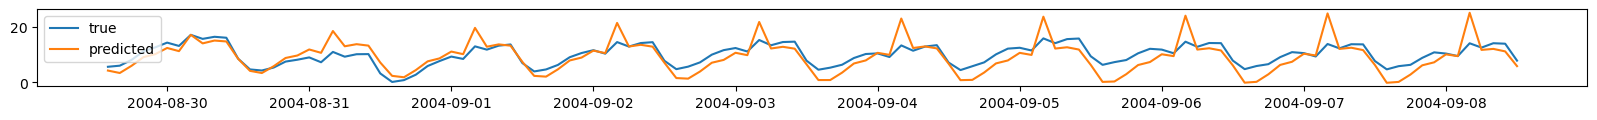

Correlation of the SARIMA model: 0.8048492540918595
RMSE of the SARIMA model: 3.467104703823106




08/01/2025 15:16:55 Iteration 12/40
2004-11-06 20:00:00 2004-11-16 20:00:00
Preprocessing train set...


 45%|████▌     | 45/100 [04:44<05:47,  6.32s/it]


Preprocessing test set...


 44%|████▍     | 44/100 [04:25<05:37,  6.04s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9446      0.002   1101.125      0.000       1.941       1.948
ar.L2         -0.9824      0.002   -551.436      0.000      -0.986      -0.979
ma.L1         -0.7175      0.005   -145.674      0.000      -0.727      -0.708
ma.L2          0.4171      0.006     68.178      0.000       0.405       0.429
ar.S.L12       0.0186      0.010      1.832      0.067      -0.001       0.039
ar.S.L24       0.7109      0.009     82.671      0.000       0.694       0.728
ma.S.L12       0.8573      0.011     76.300      0.000       0.835       0.879
ma.S.L24       0.2126      0.008     27.152      0.000       0.197       0.228
sigma2         0.0277      0.000    156.432      0.000       0.027       0.028
Sarima estimation converged? :True


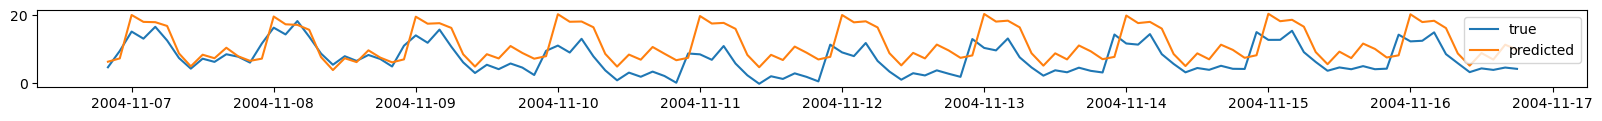

Correlation of the SARIMA model: 0.700106525029612
RMSE of the SARIMA model: 5.491837216403089




08/01/2025 15:28:06 Iteration 13/40
2005-01-17 00:00:00 2005-01-27 00:00:00
Preprocessing train set...


 46%|████▌     | 46/100 [03:47<04:27,  4.96s/it]


Preprocessing test set...


 46%|████▌     | 46/100 [03:46<04:25,  4.92s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9434      0.002    883.038      0.000       1.939       1.948
ar.L2         -0.9805      0.002   -449.357      0.000      -0.985      -0.976
ma.L1         -0.7231      0.005   -140.561      0.000      -0.733      -0.713
ma.L2          0.4066      0.007     61.907      0.000       0.394       0.420
ar.S.L12       0.0588      0.015      3.868      0.000       0.029       0.089
ar.S.L24       0.6635      0.014     47.306      0.000       0.636       0.691
ma.S.L12       0.8041      0.016     49.045      0.000       0.772       0.836
ma.S.L24       0.1977      0.008     23.640      0.000       0.181       0.214
sigma2         0.0263      0.000    131.487      0.000       0.026       0.027
Sarima estimation converged? :True


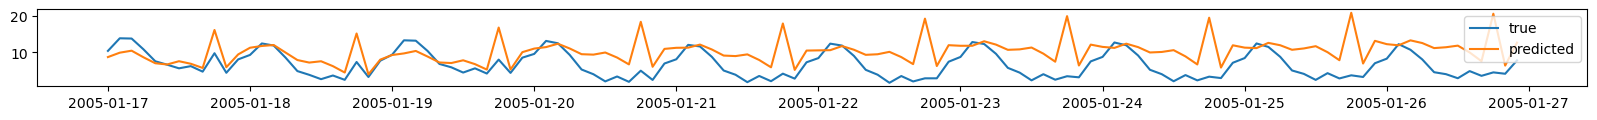

Correlation of the SARIMA model: 0.2593525177136166
RMSE of the SARIMA model: 5.577716455664683




08/01/2025 15:38:32 Iteration 14/40
2005-05-07 12:00:00 2005-05-17 12:00:00
Preprocessing train set...


 46%|████▌     | 46/100 [03:24<03:59,  4.44s/it]


Preprocessing test set...


 45%|████▌     | 45/100 [03:14<03:57,  4.32s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9416      0.002    884.291      0.000       1.937       1.946
ar.L2         -0.9791      0.002   -441.521      0.000      -0.983      -0.975
ma.L1         -0.7260      0.005   -151.148      0.000      -0.735      -0.717
ma.L2          0.3901      0.007     59.676      0.000       0.377       0.403
ar.S.L12       0.1186      0.020      5.977      0.000       0.080       0.158
ar.S.L24       0.6139      0.018     33.566      0.000       0.578       0.650
ma.S.L12       0.7967      0.021     37.752      0.000       0.755       0.838
ma.S.L24       0.2242      0.009     26.366      0.000       0.208       0.241
sigma2         0.0233      0.000    141.304      0.000       0.023       0.024
Sarima estimation converged? :True


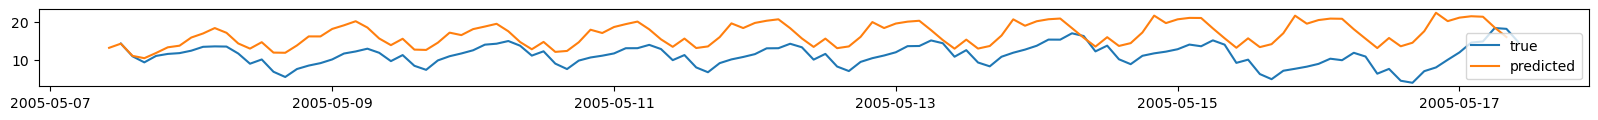

Correlation of the SARIMA model: 0.5662076195178678
RMSE of the SARIMA model: 6.1499742503819




08/01/2025 15:47:29 Iteration 15/40
2005-05-14 06:00:00 2005-05-24 06:00:00
Preprocessing train set...


 44%|████▍     | 44/100 [04:27<05:39,  6.07s/it]


Preprocessing test set...


 45%|████▌     | 45/100 [04:41<05:44,  6.27s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9416      0.002    937.415      0.000       1.938       1.946
ar.L2         -0.9791      0.002   -473.291      0.000      -0.983      -0.975
ma.L1         -0.6977      0.006   -124.820      0.000      -0.709      -0.687
ma.L2          0.3813      0.006     60.832      0.000       0.369       0.394
ar.S.L12       0.1524      0.023      6.543      0.000       0.107       0.198
ar.S.L24       0.5945      0.021     27.762      0.000       0.553       0.636
ma.S.L12       0.7731      0.024     31.677      0.000       0.725       0.821
ma.S.L24       0.2147      0.009     24.391      0.000       0.197       0.232
sigma2         0.0222      0.000    125.128      0.000       0.022       0.023
Sarima estimation converged? :True


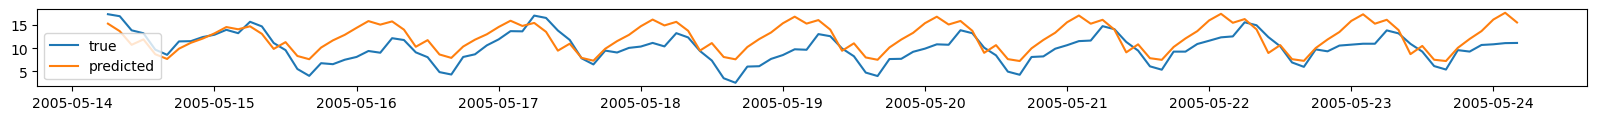

Correlation of the SARIMA model: 0.6563691963736792
RMSE of the SARIMA model: 3.362503227014643




08/01/2025 16:00:18 Iteration 16/40
2005-05-29 08:00:00 2005-06-08 08:00:00
Preprocessing train set...


 44%|████▍     | 44/100 [04:34<05:49,  6.24s/it]


Preprocessing test set...


 45%|████▌     | 45/100 [04:42<05:45,  6.28s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9419      0.002    892.087      0.000       1.938       1.946
ar.L2         -0.9795      0.002   -449.331      0.000      -0.984      -0.975
ma.L1         -0.6936      0.006   -123.825      0.000      -0.705      -0.683
ma.L2          0.3826      0.007     55.638      0.000       0.369       0.396
ar.S.L12       0.1747      0.025      6.999      0.000       0.126       0.224
ar.S.L24       0.5787      0.023     25.133      0.000       0.534       0.624
ma.S.L12       0.7656      0.026     29.704      0.000       0.715       0.816
ma.S.L24       0.2152      0.009     24.061      0.000       0.198       0.233
sigma2         0.0215      0.000    124.301      0.000       0.021       0.022
Sarima estimation converged? :True


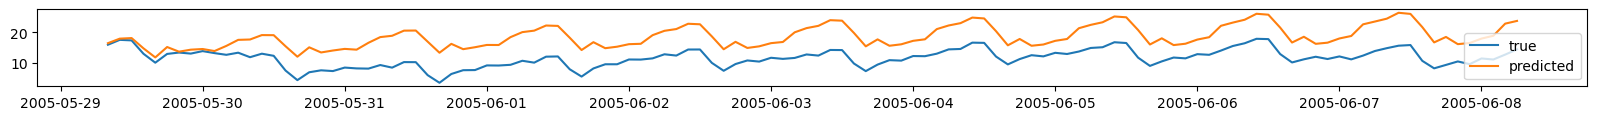

Correlation of the SARIMA model: 0.684456762343249
RMSE of the SARIMA model: 7.417709152193908




08/01/2025 16:12:31 Iteration 17/40
2005-06-11 18:00:00 2005-06-21 18:00:00
Preprocessing train set...


 43%|████▎     | 43/100 [04:31<05:59,  6.31s/it]


Preprocessing test set...


 43%|████▎     | 43/100 [04:27<05:54,  6.22s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9418      0.002    953.229      0.000       1.938       1.946
ar.L2         -0.9798      0.002   -479.986      0.000      -0.984      -0.976
ma.L1         -0.6992      0.006   -123.803      0.000      -0.710      -0.688
ma.L2          0.3844      0.007     56.958      0.000       0.371       0.398
ar.S.L12       0.1676      0.026      6.332      0.000       0.116       0.220
ar.S.L24       0.5798      0.025     23.511      0.000       0.531       0.628
ma.S.L12       0.7707      0.027     28.065      0.000       0.717       0.825
ma.S.L24       0.2144      0.008     25.686      0.000       0.198       0.231
sigma2         0.0219      0.000    128.385      0.000       0.022       0.022
Sarima estimation converged? :True


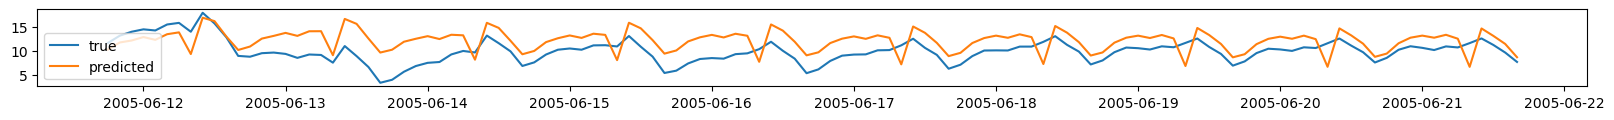

Correlation of the SARIMA model: 0.43530850431343804
RMSE of the SARIMA model: 3.2705922343868328




08/01/2025 16:24:55 Iteration 18/40
2005-08-23 10:00:00 2005-09-02 10:00:00
Preprocessing train set...


  2%|▏         | 2/100 [00:13<11:02,  6.76s/it]


Preprocessing test set...


  2%|▏         | 2/100 [00:13<11:01,  6.75s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9520      0.002   1089.879      0.000       1.948       1.955
ar.L2         -0.9887      0.002   -552.942      0.000      -0.992      -0.985
ma.L1         -0.2611      0.008    -34.422      0.000      -0.276      -0.246
ma.L2          0.3207      0.007     43.307      0.000       0.306       0.335
ar.S.L12       0.9057      0.030     29.856      0.000       0.846       0.965
ar.S.L24      -0.0217      0.028     -0.765      0.444      -0.077       0.034
ma.S.L12       0.4471      0.032     14.081      0.000       0.385       0.509
ma.S.L24       0.3095      0.014     21.955      0.000       0.282       0.337
sigma2         0.0087   7.88e-05    110.725      0.000       0.009       0.009
Sarima estimation converged? :True


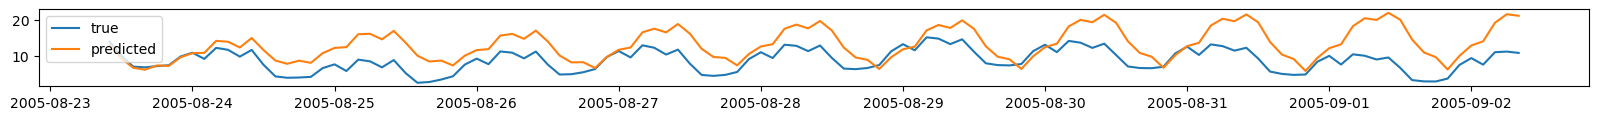

Correlation of the SARIMA model: 0.6512660373554937
RMSE of the SARIMA model: 5.489010512000838




08/01/2025 16:28:22 Iteration 19/40
2005-08-30 14:00:00 2005-09-09 14:00:00
Preprocessing train set...


  2%|▏         | 2/100 [00:18<15:17,  9.36s/it]


Preprocessing test set...


  2%|▏         | 2/100 [00:17<14:29,  8.87s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9444      0.002   1037.411      0.000       1.941       1.948
ar.L2         -0.9823      0.002   -522.260      0.000      -0.986      -0.979
ma.L1         -0.2099      0.008    -26.547      0.000      -0.225      -0.194
ma.L2          0.3242      0.008     41.160      0.000       0.309       0.340
ar.S.L12       0.9190      0.037     24.889      0.000       0.847       0.991
ar.S.L24      -0.0300      0.035     -0.869      0.385      -0.098       0.038
ma.S.L12       0.4796      0.037     12.907      0.000       0.407       0.552
ma.S.L24       0.2675      0.017     15.299      0.000       0.233       0.302
sigma2         0.0088   8.78e-05    100.595      0.000       0.009       0.009
Sarima estimation converged? :True


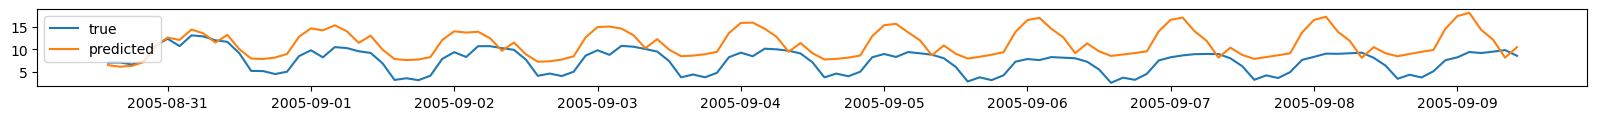

Correlation of the SARIMA model: 0.637465208817553
RMSE of the SARIMA model: 4.45052426666418




08/01/2025 16:32:49 Iteration 20/40
2005-09-10 04:00:00 2005-09-20 04:00:00
Preprocessing train set...


  2%|▏         | 2/100 [00:18<15:01,  9.20s/it]


Preprocessing test set...


  2%|▏         | 2/100 [00:18<14:52,  9.11s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9437      0.002   1035.195      0.000       1.940       1.947
ar.L2         -0.9815      0.002   -520.293      0.000      -0.985      -0.978
ma.L1         -0.2185      0.008    -27.094      0.000      -0.234      -0.203
ma.L2          0.3262      0.008     41.100      0.000       0.311       0.342
ar.S.L12       0.8886      0.037     24.175      0.000       0.817       0.961
ar.S.L24      -0.0042      0.034     -0.122      0.903      -0.072       0.063
ma.S.L12       0.5089      0.037     13.752      0.000       0.436       0.581
ma.S.L24       0.2770      0.017     16.121      0.000       0.243       0.311
sigma2         0.0088   9.23e-05     95.185      0.000       0.009       0.009
Sarima estimation converged? :True


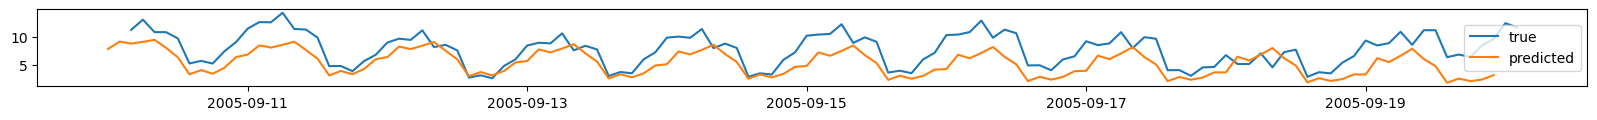

Correlation of the SARIMA model: 0.35748662154078975
RMSE of the SARIMA model: 3.8091597507421957




08/01/2025 16:37:00 Iteration 21/40
2006-12-13 22:00:00 2006-12-23 22:00:00
Preprocessing train set...


  4%|▍         | 4/100 [00:29<11:59,  7.50s/it]


Preprocessing test set...


  4%|▍         | 4/100 [00:31<12:31,  7.83s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9358      0.002    799.700      0.000       1.931       1.941
ar.L2         -0.9665      0.002   -395.941      0.000      -0.971      -0.962
ma.L1         -0.5690      0.007    -84.323      0.000      -0.582      -0.556
ma.L2          0.3742      0.007     54.789      0.000       0.361       0.388
ar.S.L12       1.6377      0.015    107.741      0.000       1.608       1.667
ar.S.L24      -0.7302      0.013    -54.733      0.000      -0.756      -0.704
ma.S.L12      -0.2490      0.018    -13.614      0.000      -0.285      -0.213
ma.S.L24      -0.0420      0.014     -2.965      0.003      -0.070      -0.014
sigma2         0.0079   6.65e-05    118.369      0.000       0.008       0.008
Sarima estimation converged? :False


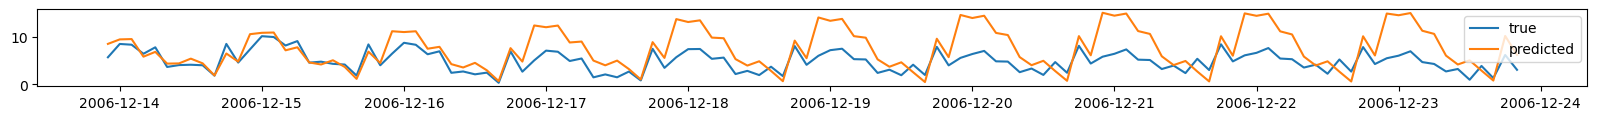

Correlation of the SARIMA model: 0.7009875345892059
RMSE of the SARIMA model: 3.970929152537741




08/01/2025 16:42:13 Iteration 22/40
2011-08-04 22:00:00 2011-08-14 22:00:00
Preprocessing train set...


  2%|▏         | 2/100 [00:18<14:56,  9.14s/it]


Preprocessing test set...


  2%|▏         | 2/100 [00:18<15:02,  9.21s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9612      0.002   1189.123      0.000       1.958       1.964
ar.L2         -0.9814      0.002   -596.998      0.000      -0.985      -0.978
ma.L1         -1.2195      0.006   -216.385      0.000      -1.231      -1.208
ma.L2          0.5239      0.006     87.503      0.000       0.512       0.536
ar.S.L12       1.6246      0.010    163.171      0.000       1.605       1.644
ar.S.L24      -0.7518      0.009    -84.831      0.000      -0.769      -0.734
ma.S.L12      -0.1814      0.013    -14.153      0.000      -0.207      -0.156
ma.S.L24       0.0696      0.012      6.032      0.000       0.047       0.092
sigma2         0.0089    7.6e-05    116.755      0.000       0.009       0.009
Sarima estimation converged? :True


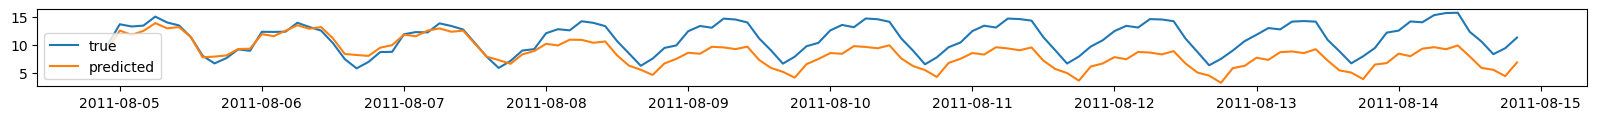

Correlation of the SARIMA model: 0.6460022539499461
RMSE of the SARIMA model: 3.4794282529855947




08/01/2025 16:46:55 Iteration 23/40
2011-09-25 16:00:00 2011-10-05 16:00:00
Preprocessing train set...


  3%|▎         | 3/100 [00:24<13:05,  8.10s/it]


Preprocessing test set...


  3%|▎         | 3/100 [00:25<13:28,  8.33s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9526      0.002   1105.019      0.000       1.949       1.956
ar.L2         -0.9773      0.002   -556.776      0.000      -0.981      -0.974
ma.L1         -1.0403      0.007   -154.427      0.000      -1.054      -1.027
ma.L2          0.5161      0.007     75.021      0.000       0.503       0.530
ar.S.L12       1.6233      0.011    148.744      0.000       1.602       1.645
ar.S.L24      -0.7457      0.010    -76.784      0.000      -0.765      -0.727
ma.S.L12      -0.2273      0.014    -16.076      0.000      -0.255      -0.200
ma.S.L24       0.1012      0.012      8.452      0.000       0.078       0.125
sigma2         0.0098   9.08e-05    107.445      0.000       0.010       0.010
Sarima estimation converged? :False


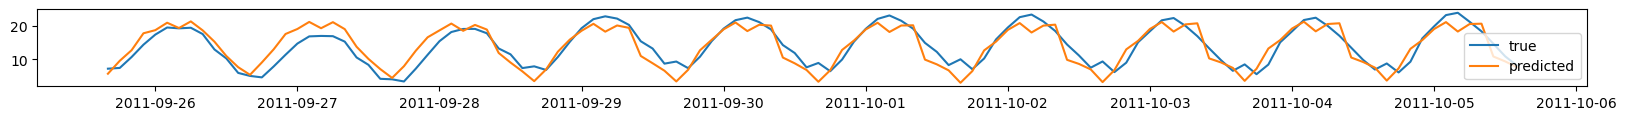

Correlation of the SARIMA model: 0.8708660237182876
RMSE of the SARIMA model: 2.880257704168608




08/01/2025 16:51:56 Iteration 24/40
2011-10-23 22:00:00 2011-11-02 22:00:00
Preprocessing train set...


  5%|▌         | 5/100 [00:36<11:29,  7.26s/it]


Preprocessing test set...


  6%|▌         | 6/100 [00:42<11:12,  7.15s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9444      0.002    987.472      0.000       1.941       1.948
ar.L2         -0.9711      0.002   -504.156      0.000      -0.975      -0.967
ma.L1         -0.9769      0.006   -169.004      0.000      -0.988      -0.966
ma.L2          0.5036      0.006     83.657      0.000       0.492       0.515
ar.S.L12       1.5955      0.013    124.118      0.000       1.570       1.621
ar.S.L24      -0.7221      0.011    -63.557      0.000      -0.744      -0.700
ma.S.L12      -0.2621      0.015    -17.688      0.000      -0.291      -0.233
ma.S.L24       0.1148      0.012      9.204      0.000       0.090       0.139
sigma2         0.0117   9.67e-05    120.900      0.000       0.012       0.012
Sarima estimation converged? :True


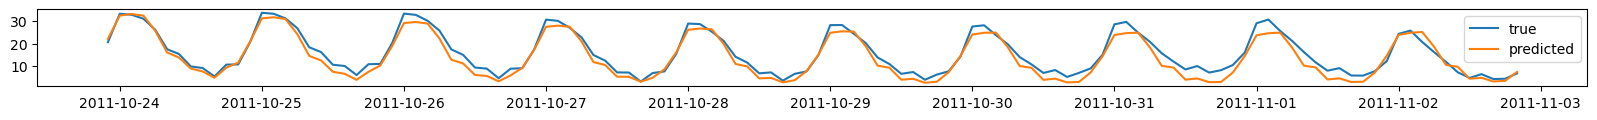

Correlation of the SARIMA model: 0.9777378353778842
RMSE of the SARIMA model: 2.6983649569809134




08/01/2025 16:57:30 Iteration 25/40
2012-03-08 02:00:00 2012-03-18 02:00:00
Preprocessing train set...


  5%|▌         | 5/100 [00:37<11:53,  7.51s/it]


Preprocessing test set...


  5%|▌         | 5/100 [00:36<11:29,  7.25s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9695      0.001   1457.028      0.000       1.967       1.972
ar.L2         -0.9872      0.001   -742.021      0.000      -0.990      -0.985
ma.L1         -1.1860      0.002   -610.241      0.000      -1.190      -1.182
ma.L2          0.3492      0.001    234.310      0.000       0.346       0.352
ar.S.L12       1.4930      0.009    172.799      0.000       1.476       1.510
ar.S.L24      -0.6846      0.007    -93.827      0.000      -0.699      -0.670
ma.S.L12      -0.0860      0.010     -8.842      0.000      -0.105      -0.067
ma.S.L24       0.1325      0.010     12.682      0.000       0.112       0.153
sigma2         0.0194   6.25e-05    309.813      0.000       0.019       0.019
Sarima estimation converged? :False


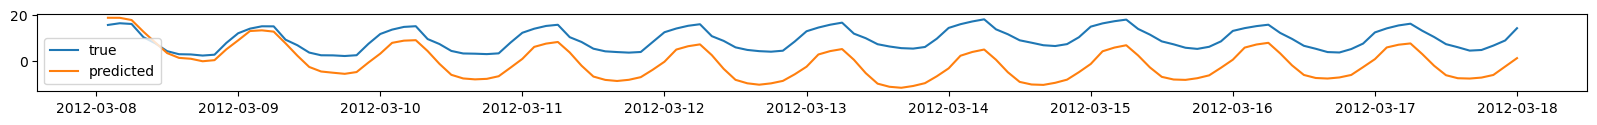

Correlation of the SARIMA model: 0.7416606078464256
RMSE of the SARIMA model: 11.327188953790882




08/01/2025 17:03:11 Iteration 26/40
2012-04-22 20:00:00 2012-05-02 20:00:00
Preprocessing train set...


  7%|▋         | 7/100 [00:49<10:54,  7.04s/it]


Preprocessing test set...


  7%|▋         | 7/100 [00:49<11:03,  7.13s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9497      0.001   1922.283      0.000       1.948       1.952
ar.L2         -0.9846      0.001   -952.189      0.000      -0.987      -0.983
ma.L1         -0.8582      0.002   -406.093      0.000      -0.862      -0.854
ma.L2          0.4250      0.002    174.527      0.000       0.420       0.430
ar.S.L12       1.5441      0.011    145.404      0.000       1.523       1.565
ar.S.L24      -0.6772      0.009    -72.790      0.000      -0.695      -0.659
ma.S.L12      -0.2951      0.012    -24.459      0.000      -0.319      -0.271
ma.S.L24       0.0433      0.009      4.615      0.000       0.025       0.062
sigma2         0.0189   7.55e-05    249.895      0.000       0.019       0.019
Sarima estimation converged? :True


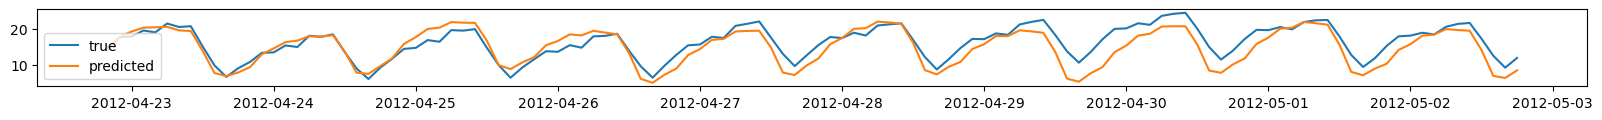

Correlation of the SARIMA model: 0.8695284080989025
RMSE of the SARIMA model: 2.7798539571031986




08/01/2025 17:07:52 Iteration 27/40
2012-07-14 06:00:00 2012-07-24 06:00:00
Preprocessing train set...


100%|██████████| 100/100 [10:15<00:00,  6.16s/it]


Preprocessing test set...


100%|██████████| 100/100 [10:13<00:00,  6.13s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9382      0.002   1278.870      0.000       1.935       1.941
ar.L2         -0.9799      0.002   -611.782      0.000      -0.983      -0.977
ma.L1         -0.7615      0.004   -172.050      0.000      -0.770      -0.753
ma.L2          0.4334      0.004    100.774      0.000       0.425       0.442
ar.S.L12       0.2884      0.029      9.938      0.000       0.232       0.345
ar.S.L24       0.3530      0.026     13.785      0.000       0.303       0.403
ma.S.L12       0.7199      0.029     24.687      0.000       0.663       0.777
ma.S.L24       0.2913      0.008     34.964      0.000       0.275       0.308
sigma2         0.0301      0.000    191.932      0.000       0.030       0.030
Sarima estimation converged? :True


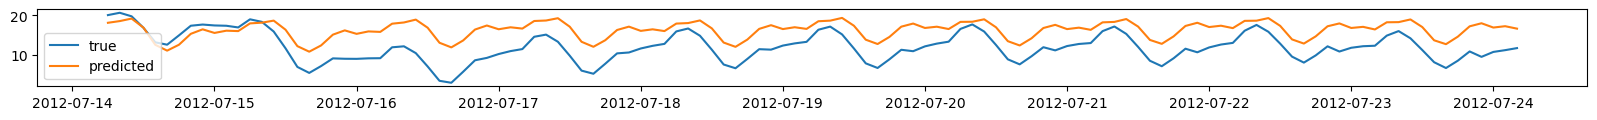

Correlation of the SARIMA model: 0.6969896979250285
RMSE of the SARIMA model: 5.119594322575996




08/01/2025 17:31:05 Iteration 28/40
2012-09-30 00:00:00 2012-10-10 00:00:00
Preprocessing train set...


100%|██████████| 100/100 [09:34<00:00,  5.74s/it]


Preprocessing test set...


100%|██████████| 100/100 [06:58<00:00,  4.19s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9409      0.001   1298.704      0.000       1.938       1.944
ar.L2         -0.9817      0.002   -624.493      0.000      -0.985      -0.979
ma.L1         -0.7580      0.004   -172.606      0.000      -0.767      -0.749
ma.L2          0.4283      0.004    100.010      0.000       0.420       0.437
ar.S.L12       0.0925      0.016      5.918      0.000       0.062       0.123
ar.S.L24       0.5235      0.015     34.419      0.000       0.494       0.553
ma.S.L12       0.8982      0.016     55.821      0.000       0.867       0.930
ma.S.L24       0.3309      0.007     48.410      0.000       0.318       0.344
sigma2         0.0302      0.000    190.747      0.000       0.030       0.031
Sarima estimation converged? :True


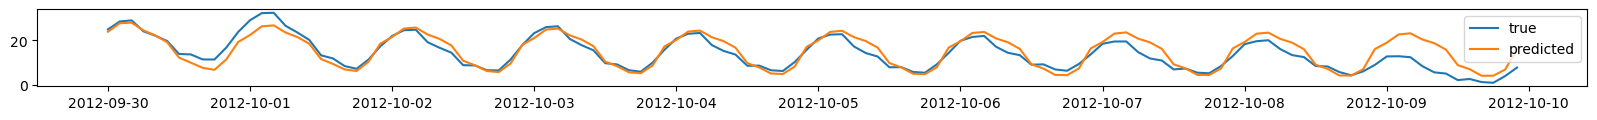

Correlation of the SARIMA model: 0.8770852271995151
RMSE of the SARIMA model: 3.7649814095064174




08/01/2025 17:49:41 Iteration 29/40
2012-10-07 06:00:00 2012-10-17 06:00:00
Preprocessing train set...


100%|██████████| 100/100 [07:16<00:00,  4.37s/it]


Preprocessing test set...


100%|██████████| 100/100 [07:04<00:00,  4.25s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9378      0.002   1181.921      0.000       1.935       1.941
ar.L2         -0.9788      0.002   -567.043      0.000      -0.982      -0.975
ma.L1         -0.7314      0.004   -164.528      0.000      -0.740      -0.723
ma.L2          0.4260      0.004     99.388      0.000       0.418       0.434
ar.S.L12       0.1093      0.015      7.089      0.000       0.079       0.139
ar.S.L24       0.5097      0.015     33.780      0.000       0.480       0.539
ma.S.L12       0.8428      0.016     52.991      0.000       0.812       0.874
ma.S.L24       0.3273      0.007     45.948      0.000       0.313       0.341
sigma2         0.0319      0.000    188.507      0.000       0.032       0.032
Sarima estimation converged? :True


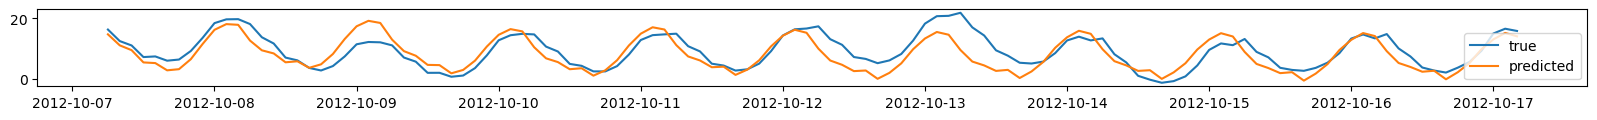

Correlation of the SARIMA model: 0.7902200992026356
RMSE of the SARIMA model: 3.617982825546178




08/01/2025 18:06:51 Iteration 30/40
2012-11-13 00:00:00 2012-11-23 00:00:00
Preprocessing train set...


100%|██████████| 100/100 [07:05<00:00,  4.25s/it]


Preprocessing test set...


100%|██████████| 100/100 [06:50<00:00,  4.10s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9322      0.002   1094.738      0.000       1.929       1.936
ar.L2         -0.9749      0.002   -513.457      0.000      -0.979      -0.971
ma.L1         -0.6465      0.005   -139.850      0.000      -0.656      -0.637
ma.L2          0.4026      0.004    100.651      0.000       0.395       0.410
ar.S.L12       0.4846      0.040     12.115      0.000       0.406       0.563
ar.S.L24       0.1956      0.033      5.918      0.000       0.131       0.260
ma.S.L12       0.4901      0.040     12.288      0.000       0.412       0.568
ma.S.L24       0.2327      0.009     26.154      0.000       0.215       0.250
sigma2         0.0325      0.000    196.675      0.000       0.032       0.033
Sarima estimation converged? :True


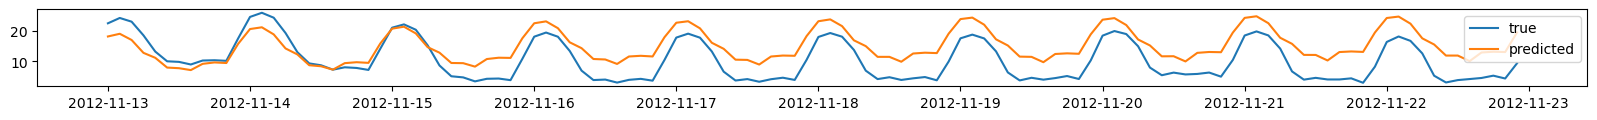

Correlation of the SARIMA model: 0.7796867116653952
RMSE of the SARIMA model: 6.126635173078587




08/01/2025 18:23:36 Iteration 31/40
2013-03-16 08:00:00 2013-03-26 08:00:00
Preprocessing train set...


  6%|▌         | 6/100 [00:30<07:51,  5.02s/it]


Preprocessing test set...


  6%|▌         | 6/100 [00:31<08:07,  5.18s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9307      0.002   1047.378      0.000       1.927       1.934
ar.L2         -0.9745      0.002   -495.293      0.000      -0.978      -0.971
ma.L1         -0.3811      0.004    -88.084      0.000      -0.390      -0.373
ma.L2          0.4027      0.003    122.324      0.000       0.396       0.409
ar.S.L12       1.7695      0.008    223.204      0.000       1.754       1.785
ar.S.L24      -0.8310      0.007   -125.118      0.000      -0.844      -0.818
ma.S.L12      -0.7768      0.009    -87.465      0.000      -0.794      -0.759
ma.S.L24       0.0728      0.009      8.343      0.000       0.056       0.090
sigma2         0.0181   8.75e-05    206.843      0.000       0.018       0.018
Sarima estimation converged? :True


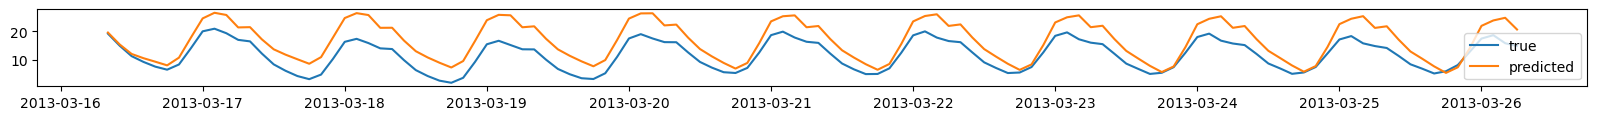

Correlation of the SARIMA model: 0.9410077185272743
RMSE of the SARIMA model: 5.482421237914584




08/01/2025 18:28:40 Iteration 32/40
2013-05-31 02:00:00 2013-06-10 02:00:00
Preprocessing train set...


100%|██████████| 100/100 [07:08<00:00,  4.29s/it]


Preprocessing test set...


100%|██████████| 100/100 [07:38<00:00,  4.58s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9349      0.001   1590.169      0.000       1.933       1.937
ar.L2         -0.9811      0.001   -736.122      0.000      -0.984      -0.978
ma.L1          0.8837      0.002    377.484      0.000       0.879       0.888
ma.L2         -0.1049      0.003    -40.835      0.000      -0.110      -0.100
ar.S.L12       0.5676      0.031     18.433      0.000       0.507       0.628
ar.S.L24       0.2376      0.029      8.172      0.000       0.181       0.295
ma.S.L12       0.4224      0.030     14.097      0.000       0.364       0.481
ma.S.L24       0.2557      0.007     34.199      0.000       0.241       0.270
sigma2         0.0083   3.56e-05    233.838      0.000       0.008       0.008
Sarima estimation converged? :False


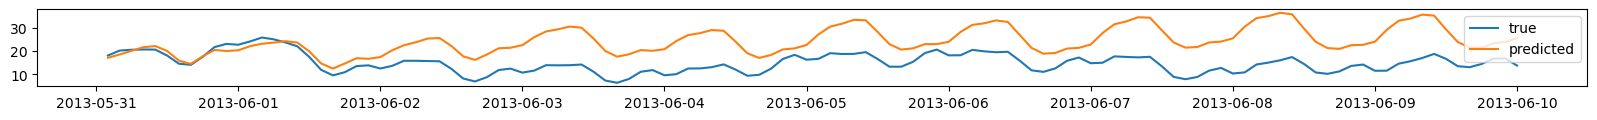

Correlation of the SARIMA model: 0.3021814031626614
RMSE of the SARIMA model: 11.024005021382179




08/01/2025 18:49:17 Iteration 33/40
2013-06-27 18:00:00 2013-07-07 18:00:00
Preprocessing train set...


100%|██████████| 100/100 [07:43<00:00,  4.64s/it]


Preprocessing test set...


100%|██████████| 100/100 [07:39<00:00,  4.60s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9380      0.001   1635.241      0.000       1.936       1.940
ar.L2         -0.9832      0.001   -759.687      0.000      -0.986      -0.981
ma.L1          0.8909      0.002    383.772      0.000       0.886       0.895
ma.L2         -0.0988      0.003    -38.691      0.000      -0.104      -0.094
ar.S.L12       0.4991      0.029     17.031      0.000       0.442       0.557
ar.S.L24       0.2897      0.028     10.422      0.000       0.235       0.344
ma.S.L12       0.4896      0.029     17.075      0.000       0.433       0.546
ma.S.L24       0.2660      0.007     37.834      0.000       0.252       0.280
sigma2         0.0083   3.57e-05    233.166      0.000       0.008       0.008
Sarima estimation converged? :True


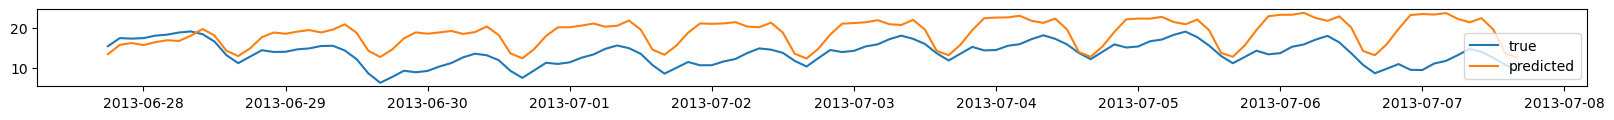

Correlation of the SARIMA model: 0.44132614431620504
RMSE of the SARIMA model: 6.131014203118756




08/01/2025 19:08:25 Iteration 34/40
2014-02-17 22:00:00 2014-02-27 22:00:00
Preprocessing train set...


  9%|▉         | 9/100 [00:47<07:58,  5.25s/it]


Preprocessing test set...


  9%|▉         | 9/100 [00:46<07:53,  5.20s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9388      0.002   1104.926      0.000       1.935       1.942
ar.L2         -0.9794      0.002   -556.032      0.000      -0.983      -0.976
ma.L1         -0.2419      0.006    -42.581      0.000      -0.253      -0.231
ma.L2          0.3123      0.002    137.273      0.000       0.308       0.317
ar.S.L12       0.5347      0.011     49.871      0.000       0.514       0.556
ar.S.L24       0.2543      0.010     26.394      0.000       0.235       0.273
ma.S.L12       0.4799      0.008     58.864      0.000       0.464       0.496
ma.S.L24       0.3816      0.004     94.811      0.000       0.374       0.389
sigma2         0.0178   8.72e-05    204.334      0.000       0.018       0.018
Sarima estimation converged? :True


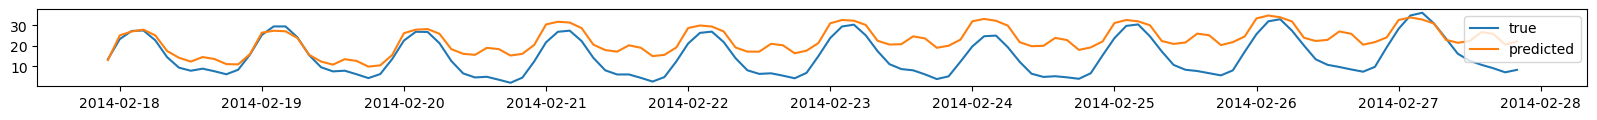

Correlation of the SARIMA model: 0.8081711383759254
RMSE of the SARIMA model: 9.570288520670243




08/01/2025 19:13:07 Iteration 35/40
2015-03-16 12:00:00 2015-03-26 12:00:00
Preprocessing train set...


 71%|███████   | 71/100 [05:31<02:15,  4.67s/it]


Preprocessing test set...


 81%|████████  | 81/100 [06:08<01:26,  4.55s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9422      0.001   1355.036      0.000       1.939       1.945
ar.L2         -0.9842      0.001   -681.874      0.000      -0.987      -0.981
ma.L1         -0.2901      0.006    -51.935      0.000      -0.301      -0.279
ma.L2          0.2803      0.003     96.567      0.000       0.275       0.286
ar.S.L12       0.1688      0.009     19.632      0.000       0.152       0.186
ar.S.L24       0.5873      0.009     64.444      0.000       0.569       0.605
ma.S.L12       1.0167      0.007    138.836      0.000       1.002       1.031
ma.S.L24       0.3878      0.003    154.950      0.000       0.383       0.393
sigma2         0.0168   8.46e-05    198.323      0.000       0.017       0.017
Sarima estimation converged? :True


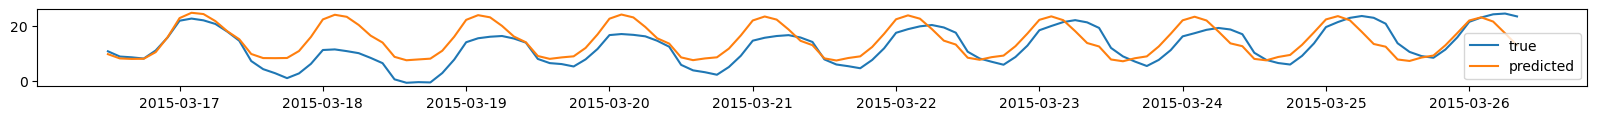

Correlation of the SARIMA model: 0.7241415499959832
RMSE of the SARIMA model: 5.181895500951603




08/01/2025 19:28:49 Iteration 36/40
2015-06-21 18:00:00 2015-07-01 18:00:00
Preprocessing train set...


 53%|█████▎    | 53/100 [04:30<04:00,  5.11s/it]


Preprocessing test set...


 62%|██████▏   | 62/100 [04:58<03:02,  4.81s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9345      0.002   1232.044      0.000       1.931       1.938
ar.L2         -0.9816      0.002   -622.901      0.000      -0.985      -0.979
ma.L1         -0.2109      0.005    -40.294      0.000      -0.221      -0.201
ma.L2          0.3329      0.002    154.233      0.000       0.329       0.337
ar.S.L12       1.8128      0.005    353.842      0.000       1.803       1.823
ar.S.L24      -0.8623      0.005   -186.576      0.000      -0.871      -0.853
ma.S.L12      -0.7712      0.007   -103.113      0.000      -0.786      -0.757
ma.S.L24       0.0241      0.007      3.435      0.001       0.010       0.038
sigma2         0.0167   9.21e-05    181.305      0.000       0.017       0.017
Sarima estimation converged? :False


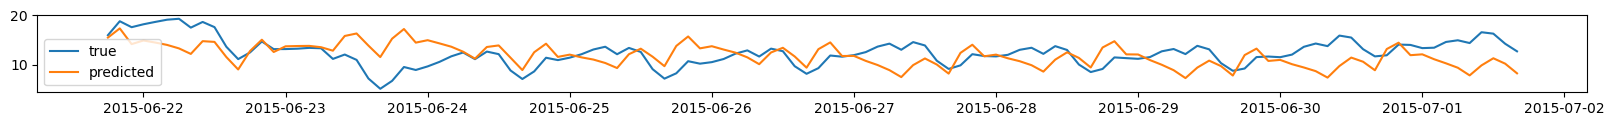

Correlation of the SARIMA model: 0.09057098375128514
RMSE of the SARIMA model: 3.3544939213127654




08/01/2025 19:42:39 Iteration 37/40
2015-10-06 14:00:00 2015-10-16 14:00:00
Preprocessing train set...


 48%|████▊     | 48/100 [04:15<04:36,  5.32s/it]


Preprocessing test set...


 46%|████▌     | 46/100 [04:05<04:48,  5.35s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9387      0.001   1666.211      0.000       1.936       1.941
ar.L2         -0.9793      0.001   -905.131      0.000      -0.981      -0.977
ma.L1         -0.2962      0.005    -59.106      0.000      -0.306      -0.286
ma.L2          0.3540      0.003    102.509      0.000       0.347       0.361
ar.S.L12       0.6627      0.010     65.027      0.000       0.643       0.683
ar.S.L24       0.1788      0.010     18.363      0.000       0.160       0.198
ma.S.L12       0.3804      0.011     35.754      0.000       0.360       0.401
ma.S.L24       0.3229      0.003    110.788      0.000       0.317       0.329
sigma2         0.0152   8.38e-05    181.649      0.000       0.015       0.015
Sarima estimation converged? :True


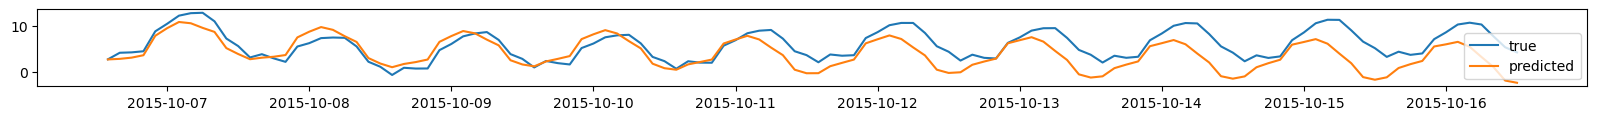

Correlation of the SARIMA model: 0.6809418427888702
RMSE of the SARIMA model: 3.1293579575538972




08/01/2025 19:55:05 Iteration 38/40
2015-12-19 12:00:00 2015-12-29 12:00:00
Preprocessing train set...


 23%|██▎       | 23/100 [02:06<07:02,  5.49s/it]


Preprocessing test set...


 21%|██        | 21/100 [02:00<07:34,  5.76s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9359      0.002   1116.376      0.000       1.933       1.939
ar.L2         -0.9810      0.002   -565.286      0.000      -0.984      -0.978
ma.L1          0.1765      0.006     28.584      0.000       0.164       0.189
ma.L2          0.3015      0.007     40.996      0.000       0.287       0.316
ar.S.L12       1.8208      0.007    249.413      0.000       1.806       1.835
ar.S.L24      -0.8700      0.007   -128.081      0.000      -0.883      -0.857
ma.S.L12      -0.8249      0.011    -77.984      0.000      -0.846      -0.804
ma.S.L24       0.2211      0.010     23.199      0.000       0.202       0.240
sigma2         0.0077   5.79e-05    132.726      0.000       0.008       0.008
Sarima estimation converged? :False


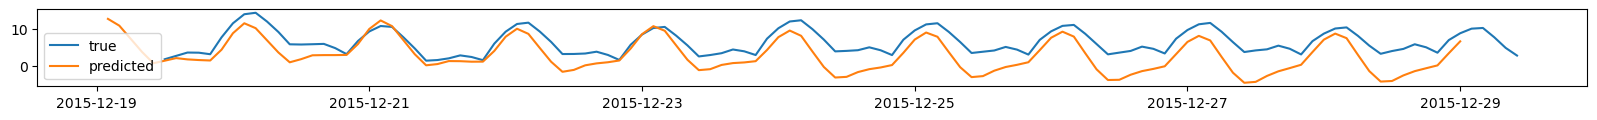

Correlation of the SARIMA model: -0.46821764372501695
RMSE of the SARIMA model: 7.42258903260737




08/01/2025 20:03:26 Iteration 39/40
2015-12-30 20:00:00 2016-01-09 20:00:00
Preprocessing train set...


 20%|██        | 20/100 [01:37<06:31,  4.89s/it]


Preprocessing test set...


 20%|██        | 20/100 [01:39<06:39,  4.99s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9367      0.002   1093.777      0.000       1.933       1.940
ar.L2         -0.9820      0.002   -555.532      0.000      -0.985      -0.979
ma.L1          0.2103      0.007     29.102      0.000       0.196       0.224
ma.L2          0.2898      0.008     34.739      0.000       0.273       0.306
ar.S.L12       1.8202      0.007    256.278      0.000       1.806       1.834
ar.S.L24      -0.8696      0.007   -131.617      0.000      -0.883      -0.857
ma.S.L12      -0.8122      0.011    -75.132      0.000      -0.833      -0.791
ma.S.L24       0.2171      0.010     21.764      0.000       0.198       0.237
sigma2         0.0075    6.7e-05    111.670      0.000       0.007       0.008
Sarima estimation converged? :False


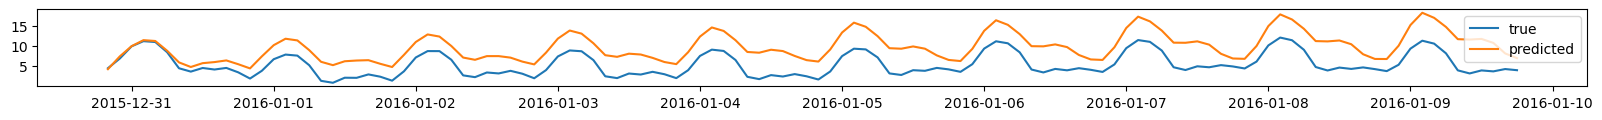

Correlation of the SARIMA model: 0.8520043535723238
RMSE of the SARIMA model: 4.690416247050326




08/01/2025 20:11:07 Iteration 40/40
2016-10-12 10:00:00 2016-10-22 10:00:00
Preprocessing train set...


  5%|▌         | 5/100 [00:30<09:36,  6.07s/it]


Preprocessing test set...


  5%|▌         | 5/100 [00:31<09:54,  6.25s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9385      0.002   1142.588      0.000       1.935       1.942
ar.L2         -0.9899      0.002   -581.836      0.000      -0.993      -0.987
ma.L1          1.2630      0.008    159.659      0.000       1.247       1.278
ma.L2          0.2668      0.008     33.658      0.000       0.251       0.282
ar.S.L12       1.7936      0.011    169.575      0.000       1.773       1.814
ar.S.L24      -0.8409      0.010    -87.767      0.000      -0.860      -0.822
ma.S.L12      -0.7518      0.015    -51.127      0.000      -0.781      -0.723
ma.S.L24       0.0715      0.011      6.762      0.000       0.051       0.092
sigma2         0.0025   2.67e-05     94.146      0.000       0.002       0.003
Sarima estimation converged? :False


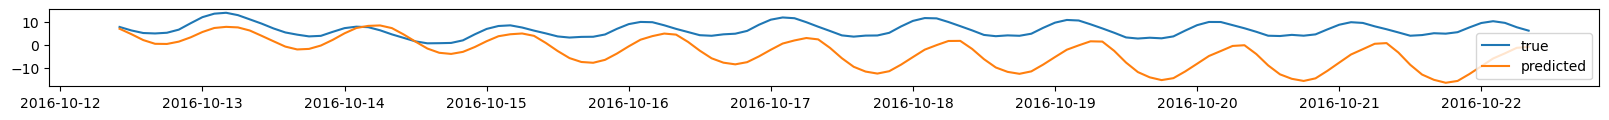

Correlation of the SARIMA model: 0.46517887501787986
RMSE of the SARIMA model: 11.40723520437789






In [22]:
results = {'sarima_summary':[], 'sarima_converged':[], 'sarima_correlation':[], 'sarima_rmse':[]}
for ix, (start, end) in enumerate(storms):
    dt_t = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
    print('{} Iteration {}/{}'.format(dt_t, ix+1, len(storms)))
    print(start - timedelta(days=1), start + timedelta(days=9))
    
    ### Preprocess train and test
    train, test = get_train_and_test(train_start=start - timedelta(days=365*2+1), test_start=start - timedelta(days=1), test_end=start + timedelta(days=9), trajectory_window=120)
    
    ### SARIMA
    model = SARIMAX(train, order=(2, 0, 2), seasonal_order=(2, 1, 2, 12)).fit(maxiter=100)
    results['sarima_summary'].append(model.summary().tables[1])
    print(results['sarima_summary'][-1])
    results['sarima_converged'].append(model.mle_retvals['converged'])
    print('Sarima estimation converged? :{}'.format(results['sarima_converged'][-1]))
    predict = model.forecast(steps=len(test))
    plt.figure(figsize=(20, 1))
    plt.plot(test, label='true')
    plt.plot(predict, label='predicted')
    plt.legend()
    plt.show()
    results['sarima_correlation'].append(pearsonr(test, predict).statistic)
    results['sarima_rmse'].append(np.sqrt(mean_squared_error(test, predict)))
    print('Correlation of the SARIMA model: {}'.format(results['sarima_correlation'][-1]))
    print('RMSE of the SARIMA model: {}'.format(results['sarima_rmse'][-1]))
    print('\n\n\n')

    with open('results_sarima.txt', 'w') as file:
        file.write('='*100)
        file.write('\n')
        file.write('SARIMA\n')
        file.write('='*100)
        file.write('\n')
        for key, value in results.items():
            file.write(f"{key}: {value}\n")

08/01/2025 15:05:20 Iteration 11/40
2004-08-29 14:00:00 2004-09-08 14:00:00
Preprocessing train set...


 45%|████▌     | 45/100 [04:41<05:44,  6.26s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9416      0.002   1133.407      0.000       1.938       1.945
ar.L2         -0.9804      0.002   -586.826      0.000      -0.984      -0.977
ma.L1         -0.7494      0.004   -194.741      0.000      -0.757      -0.742
ma.L2          0.4299      0.004     99.555      0.000       0.421       0.438
ar.S.L12       0.0783      0.014      5.412      0.000       0.050       0.107
ar.S.L24       0.6482      0.014     46.654      0.000       0.621       0.675
ma.S.L12       0.8096      0.014     57.014      0.000       0.782       0.837
ma.S.L24       0.2266      0.007     31.994      0.000       0.213       0.241
sigma2         0.0406      0.000    192.644      0.000       0.040       0.041
Sarima estimation converged? :True


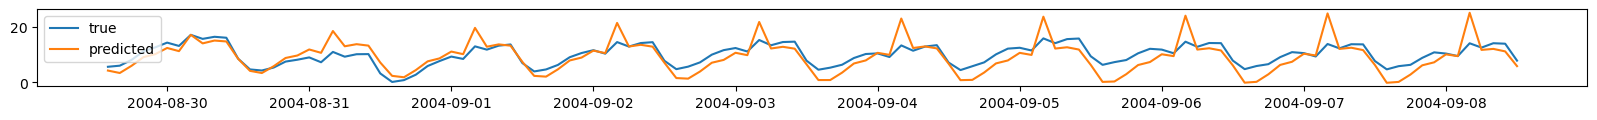

Correlation of the SARIMA model: 0.8048492540918595
RMSE of the SARIMA model: 3.467104703823106




08/01/2025 15:16:55 Iteration 12/40
2004-11-06 20:00:00 2004-11-16 20:00:00
Preprocessing train set...


 45%|████▌     | 45/100 [04:44<05:47,  6.32s/it]


Preprocessing test set...


 44%|████▍     | 44/100 [04:25<05:37,  6.04s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9446      0.002   1101.125      0.000       1.941       1.948
ar.L2         -0.9824      0.002   -551.436      0.000      -0.986      -0.979
ma.L1         -0.7175      0.005   -145.674      0.000      -0.727      -0.708
ma.L2          0.4171      0.006     68.178      0.000       0.405       0.429
ar.S.L12       0.0186      0.010      1.832      0.067      -0.001       0.039
ar.S.L24       0.7109      0.009     82.671      0.000       0.694       0.728
ma.S.L12       0.8573      0.011     76.300      0.000       0.835       0.879
ma.S.L24       0.2126      0.008     27.152      0.000       0.197       0.228
sigma2         0.0277      0.000    156.432      0.000       0.027       0.028
Sarima estimation converged? :True


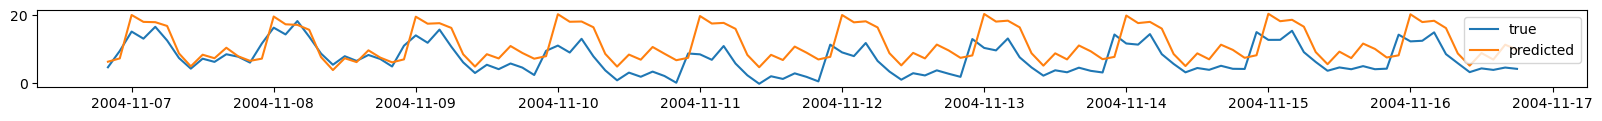

Correlation of the SARIMA model: 0.700106525029612
RMSE of the SARIMA model: 5.491837216403089




08/01/2025 15:28:06 Iteration 13/40
2005-01-17 00:00:00 2005-01-27 00:00:00
Preprocessing train set...


 46%|████▌     | 46/100 [03:47<04:27,  4.96s/it]


Preprocessing test set...


 46%|████▌     | 46/100 [03:46<04:25,  4.92s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9434      0.002    883.038      0.000       1.939       1.948
ar.L2         -0.9805      0.002   -449.357      0.000      -0.985      -0.976
ma.L1         -0.7231      0.005   -140.561      0.000      -0.733      -0.713
ma.L2          0.4066      0.007     61.907      0.000       0.394       0.420
ar.S.L12       0.0588      0.015      3.868      0.000       0.029       0.089
ar.S.L24       0.6635      0.014     47.306      0.000       0.636       0.691
ma.S.L12       0.8041      0.016     49.045      0.000       0.772       0.836
ma.S.L24       0.1977      0.008     23.640      0.000       0.181       0.214
sigma2         0.0263      0.000    131.487      0.000       0.026       0.027
Sarima estimation converged? :True


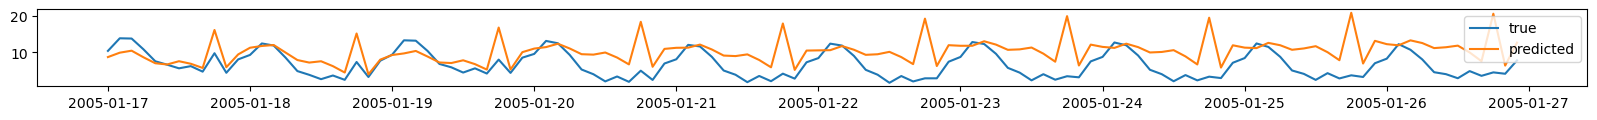

Correlation of the SARIMA model: 0.2593525177136166
RMSE of the SARIMA model: 5.577716455664683




08/01/2025 15:38:32 Iteration 14/40
2005-05-07 12:00:00 2005-05-17 12:00:00
Preprocessing train set...


 46%|████▌     | 46/100 [03:24<03:59,  4.44s/it]


Preprocessing test set...


 45%|████▌     | 45/100 [03:14<03:57,  4.32s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9416      0.002    884.291      0.000       1.937       1.946
ar.L2         -0.9791      0.002   -441.521      0.000      -0.983      -0.975
ma.L1         -0.7260      0.005   -151.148      0.000      -0.735      -0.717
ma.L2          0.3901      0.007     59.676      0.000       0.377       0.403
ar.S.L12       0.1186      0.020      5.977      0.000       0.080       0.158
ar.S.L24       0.6139      0.018     33.566      0.000       0.578       0.650
ma.S.L12       0.7967      0.021     37.752      0.000       0.755       0.838
ma.S.L24       0.2242      0.009     26.366      0.000       0.208       0.241
sigma2         0.0233      0.000    141.304      0.000       0.023       0.024
Sarima estimation converged? :True


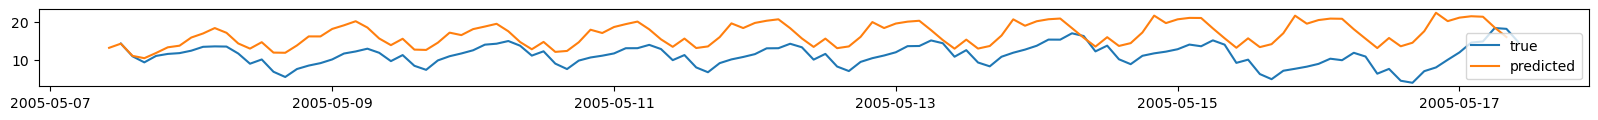

Correlation of the SARIMA model: 0.5662076195178678
RMSE of the SARIMA model: 6.1499742503819




08/01/2025 15:47:29 Iteration 15/40
2005-05-14 06:00:00 2005-05-24 06:00:00
Preprocessing train set...


 44%|████▍     | 44/100 [04:27<05:39,  6.07s/it]


Preprocessing test set...


 45%|████▌     | 45/100 [04:41<05:44,  6.27s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9416      0.002    937.415      0.000       1.938       1.946
ar.L2         -0.9791      0.002   -473.291      0.000      -0.983      -0.975
ma.L1         -0.6977      0.006   -124.820      0.000      -0.709      -0.687
ma.L2          0.3813      0.006     60.832      0.000       0.369       0.394
ar.S.L12       0.1524      0.023      6.543      0.000       0.107       0.198
ar.S.L24       0.5945      0.021     27.762      0.000       0.553       0.636
ma.S.L12       0.7731      0.024     31.677      0.000       0.725       0.821
ma.S.L24       0.2147      0.009     24.391      0.000       0.197       0.232
sigma2         0.0222      0.000    125.128      0.000       0.022       0.023
Sarima estimation converged? :True


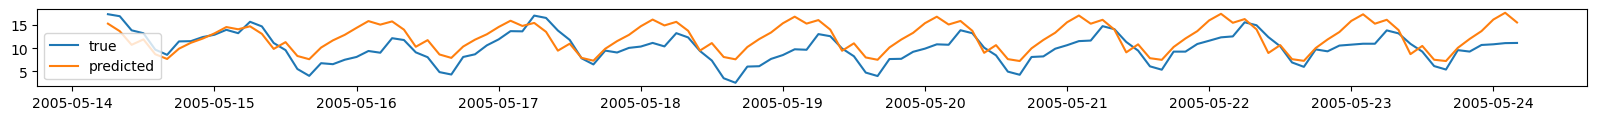

Correlation of the SARIMA model: 0.6563691963736792
RMSE of the SARIMA model: 3.362503227014643




08/01/2025 16:00:18 Iteration 16/40
2005-05-29 08:00:00 2005-06-08 08:00:00
Preprocessing train set...


 44%|████▍     | 44/100 [04:34<05:49,  6.24s/it]


Preprocessing test set...


 45%|████▌     | 45/100 [04:42<05:45,  6.28s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9419      0.002    892.087      0.000       1.938       1.946
ar.L2         -0.9795      0.002   -449.331      0.000      -0.984      -0.975
ma.L1         -0.6936      0.006   -123.825      0.000      -0.705      -0.683
ma.L2          0.3826      0.007     55.638      0.000       0.369       0.396
ar.S.L12       0.1747      0.025      6.999      0.000       0.126       0.224
ar.S.L24       0.5787      0.023     25.133      0.000       0.534       0.624
ma.S.L12       0.7656      0.026     29.704      0.000       0.715       0.816
ma.S.L24       0.2152      0.009     24.061      0.000       0.198       0.233
sigma2         0.0215      0.000    124.301      0.000       0.021       0.022
Sarima estimation converged? :True


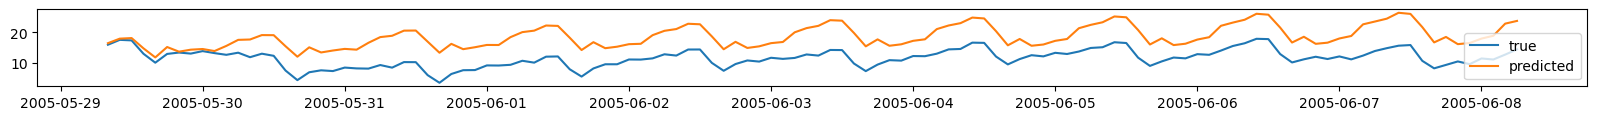

Correlation of the SARIMA model: 0.684456762343249
RMSE of the SARIMA model: 7.417709152193908




08/01/2025 16:12:31 Iteration 17/40
2005-06-11 18:00:00 2005-06-21 18:00:00
Preprocessing train set...


 43%|████▎     | 43/100 [04:31<05:59,  6.31s/it]


Preprocessing test set...


 43%|████▎     | 43/100 [04:27<05:54,  6.22s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9418      0.002    953.229      0.000       1.938       1.946
ar.L2         -0.9798      0.002   -479.986      0.000      -0.984      -0.976
ma.L1         -0.6992      0.006   -123.803      0.000      -0.710      -0.688
ma.L2          0.3844      0.007     56.958      0.000       0.371       0.398
ar.S.L12       0.1676      0.026      6.332      0.000       0.116       0.220
ar.S.L24       0.5798      0.025     23.511      0.000       0.531       0.628
ma.S.L12       0.7707      0.027     28.065      0.000       0.717       0.825
ma.S.L24       0.2144      0.008     25.686      0.000       0.198       0.231
sigma2         0.0219      0.000    128.385      0.000       0.022       0.022
Sarima estimation converged? :True


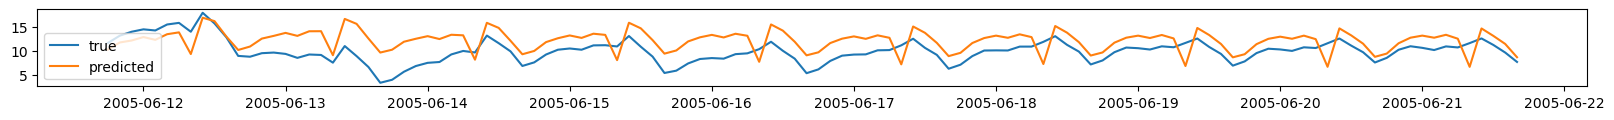

Correlation of the SARIMA model: 0.43530850431343804
RMSE of the SARIMA model: 3.2705922343868328




08/01/2025 16:24:55 Iteration 18/40
2005-08-23 10:00:00 2005-09-02 10:00:00
Preprocessing train set...


  2%|▏         | 2/100 [00:13<11:02,  6.76s/it]


Preprocessing test set...


  2%|▏         | 2/100 [00:13<11:01,  6.75s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9520      0.002   1089.879      0.000       1.948       1.955
ar.L2         -0.9887      0.002   -552.942      0.000      -0.992      -0.985
ma.L1         -0.2611      0.008    -34.422      0.000      -0.276      -0.246
ma.L2          0.3207      0.007     43.307      0.000       0.306       0.335
ar.S.L12       0.9057      0.030     29.856      0.000       0.846       0.965
ar.S.L24      -0.0217      0.028     -0.765      0.444      -0.077       0.034
ma.S.L12       0.4471      0.032     14.081      0.000       0.385       0.509
ma.S.L24       0.3095      0.014     21.955      0.000       0.282       0.337
sigma2         0.0087   7.88e-05    110.725      0.000       0.009       0.009
Sarima estimation converged? :True


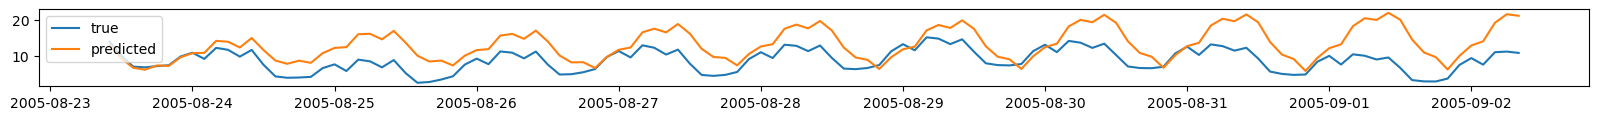

Correlation of the SARIMA model: 0.6512660373554937
RMSE of the SARIMA model: 5.489010512000838




08/01/2025 16:28:22 Iteration 19/40
2005-08-30 14:00:00 2005-09-09 14:00:00
Preprocessing train set...


  2%|▏         | 2/100 [00:18<15:17,  9.36s/it]


Preprocessing test set...


  2%|▏         | 2/100 [00:17<14:29,  8.87s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9444      0.002   1037.411      0.000       1.941       1.948
ar.L2         -0.9823      0.002   -522.260      0.000      -0.986      -0.979
ma.L1         -0.2099      0.008    -26.547      0.000      -0.225      -0.194
ma.L2          0.3242      0.008     41.160      0.000       0.309       0.340
ar.S.L12       0.9190      0.037     24.889      0.000       0.847       0.991
ar.S.L24      -0.0300      0.035     -0.869      0.385      -0.098       0.038
ma.S.L12       0.4796      0.037     12.907      0.000       0.407       0.552
ma.S.L24       0.2675      0.017     15.299      0.000       0.233       0.302
sigma2         0.0088   8.78e-05    100.595      0.000       0.009       0.009
Sarima estimation converged? :True


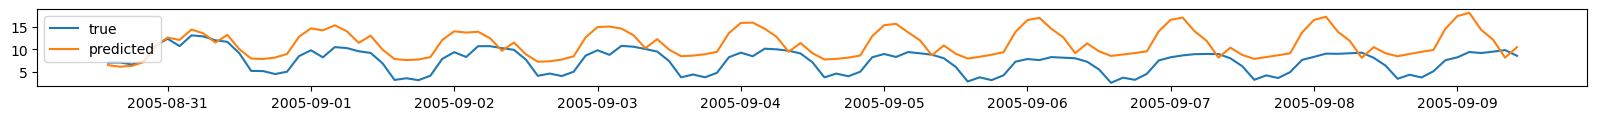

Correlation of the SARIMA model: 0.637465208817553
RMSE of the SARIMA model: 4.45052426666418




08/01/2025 16:32:49 Iteration 20/40
2005-09-10 04:00:00 2005-09-20 04:00:00
Preprocessing train set...


  2%|▏         | 2/100 [00:18<15:01,  9.20s/it]


Preprocessing test set...


  2%|▏         | 2/100 [00:18<14:52,  9.11s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9437      0.002   1035.195      0.000       1.940       1.947
ar.L2         -0.9815      0.002   -520.293      0.000      -0.985      -0.978
ma.L1         -0.2185      0.008    -27.094      0.000      -0.234      -0.203
ma.L2          0.3262      0.008     41.100      0.000       0.311       0.342
ar.S.L12       0.8886      0.037     24.175      0.000       0.817       0.961
ar.S.L24      -0.0042      0.034     -0.122      0.903      -0.072       0.063
ma.S.L12       0.5089      0.037     13.752      0.000       0.436       0.581
ma.S.L24       0.2770      0.017     16.121      0.000       0.243       0.311
sigma2         0.0088   9.23e-05     95.185      0.000       0.009       0.009
Sarima estimation converged? :True


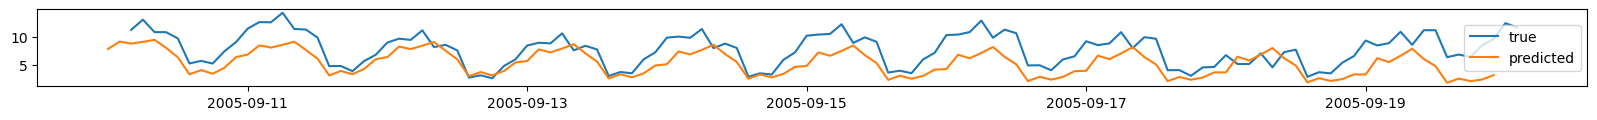

Correlation of the SARIMA model: 0.35748662154078975
RMSE of the SARIMA model: 3.8091597507421957




08/01/2025 16:37:00 Iteration 21/40
2006-12-13 22:00:00 2006-12-23 22:00:00
Preprocessing train set...


  4%|▍         | 4/100 [00:29<11:59,  7.50s/it]


Preprocessing test set...


  4%|▍         | 4/100 [00:31<12:31,  7.83s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9358      0.002    799.700      0.000       1.931       1.941
ar.L2         -0.9665      0.002   -395.941      0.000      -0.971      -0.962
ma.L1         -0.5690      0.007    -84.323      0.000      -0.582      -0.556
ma.L2          0.3742      0.007     54.789      0.000       0.361       0.388
ar.S.L12       1.6377      0.015    107.741      0.000       1.608       1.667
ar.S.L24      -0.7302      0.013    -54.733      0.000      -0.756      -0.704
ma.S.L12      -0.2490      0.018    -13.614      0.000      -0.285      -0.213
ma.S.L24      -0.0420      0.014     -2.965      0.003      -0.070      -0.014
sigma2         0.0079   6.65e-05    118.369      0.000       0.008       0.008
Sarima estimation converged? :False


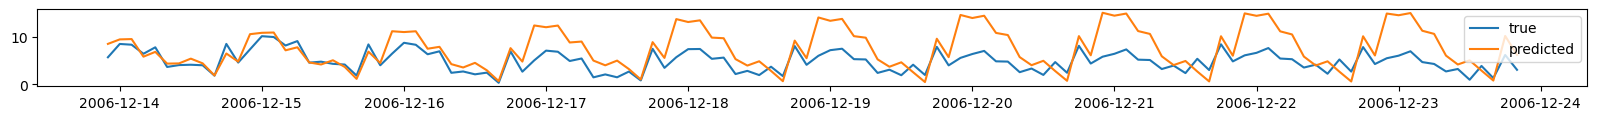

Correlation of the SARIMA model: 0.7009875345892059
RMSE of the SARIMA model: 3.970929152537741




08/01/2025 16:42:13 Iteration 22/40
2011-08-04 22:00:00 2011-08-14 22:00:00
Preprocessing train set...


  2%|▏         | 2/100 [00:18<14:56,  9.14s/it]


Preprocessing test set...


  2%|▏         | 2/100 [00:18<15:02,  9.21s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9612      0.002   1189.123      0.000       1.958       1.964
ar.L2         -0.9814      0.002   -596.998      0.000      -0.985      -0.978
ma.L1         -1.2195      0.006   -216.385      0.000      -1.231      -1.208
ma.L2          0.5239      0.006     87.503      0.000       0.512       0.536
ar.S.L12       1.6246      0.010    163.171      0.000       1.605       1.644
ar.S.L24      -0.7518      0.009    -84.831      0.000      -0.769      -0.734
ma.S.L12      -0.1814      0.013    -14.153      0.000      -0.207      -0.156
ma.S.L24       0.0696      0.012      6.032      0.000       0.047       0.092
sigma2         0.0089    7.6e-05    116.755      0.000       0.009       0.009
Sarima estimation converged? :True


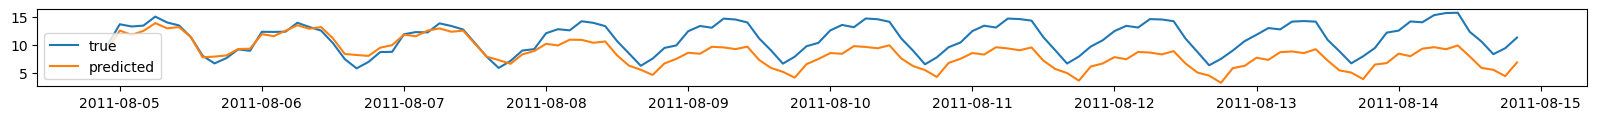

Correlation of the SARIMA model: 0.6460022539499461
RMSE of the SARIMA model: 3.4794282529855947




08/01/2025 16:46:55 Iteration 23/40
2011-09-25 16:00:00 2011-10-05 16:00:00
Preprocessing train set...


  3%|▎         | 3/100 [00:24<13:05,  8.10s/it]


Preprocessing test set...


  3%|▎         | 3/100 [00:25<13:28,  8.33s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9526      0.002   1105.019      0.000       1.949       1.956
ar.L2         -0.9773      0.002   -556.776      0.000      -0.981      -0.974
ma.L1         -1.0403      0.007   -154.427      0.000      -1.054      -1.027
ma.L2          0.5161      0.007     75.021      0.000       0.503       0.530
ar.S.L12       1.6233      0.011    148.744      0.000       1.602       1.645
ar.S.L24      -0.7457      0.010    -76.784      0.000      -0.765      -0.727
ma.S.L12      -0.2273      0.014    -16.076      0.000      -0.255      -0.200
ma.S.L24       0.1012      0.012      8.452      0.000       0.078       0.125
sigma2         0.0098   9.08e-05    107.445      0.000       0.010       0.010
Sarima estimation converged? :False


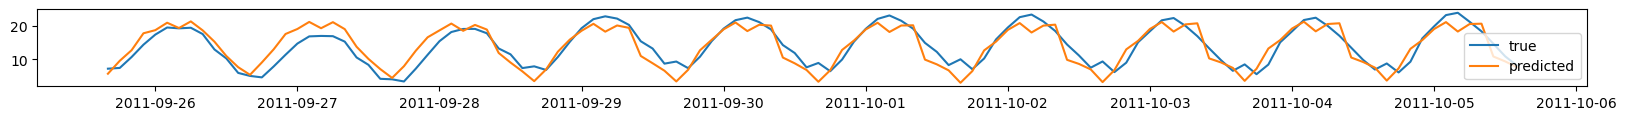

Correlation of the SARIMA model: 0.8708660237182876
RMSE of the SARIMA model: 2.880257704168608




08/01/2025 16:51:56 Iteration 24/40
2011-10-23 22:00:00 2011-11-02 22:00:00
Preprocessing train set...


  5%|▌         | 5/100 [00:36<11:29,  7.26s/it]


Preprocessing test set...


  6%|▌         | 6/100 [00:42<11:12,  7.15s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9444      0.002    987.472      0.000       1.941       1.948
ar.L2         -0.9711      0.002   -504.156      0.000      -0.975      -0.967
ma.L1         -0.9769      0.006   -169.004      0.000      -0.988      -0.966
ma.L2          0.5036      0.006     83.657      0.000       0.492       0.515
ar.S.L12       1.5955      0.013    124.118      0.000       1.570       1.621
ar.S.L24      -0.7221      0.011    -63.557      0.000      -0.744      -0.700
ma.S.L12      -0.2621      0.015    -17.688      0.000      -0.291      -0.233
ma.S.L24       0.1148      0.012      9.204      0.000       0.090       0.139
sigma2         0.0117   9.67e-05    120.900      0.000       0.012       0.012
Sarima estimation converged? :True


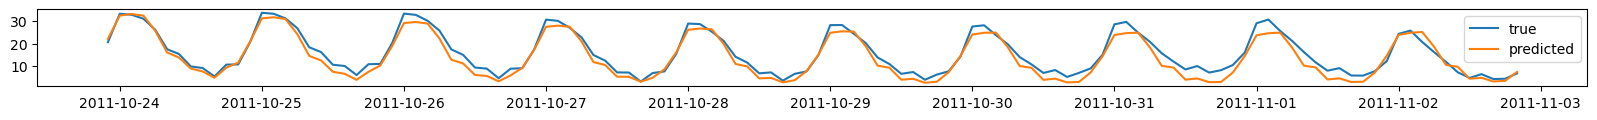

Correlation of the SARIMA model: 0.9777378353778842
RMSE of the SARIMA model: 2.6983649569809134




08/01/2025 16:57:30 Iteration 25/40
2012-03-08 02:00:00 2012-03-18 02:00:00
Preprocessing train set...


  5%|▌         | 5/100 [00:37<11:53,  7.51s/it]


Preprocessing test set...


  5%|▌         | 5/100 [00:36<11:29,  7.25s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9695      0.001   1457.028      0.000       1.967       1.972
ar.L2         -0.9872      0.001   -742.021      0.000      -0.990      -0.985
ma.L1         -1.1860      0.002   -610.241      0.000      -1.190      -1.182
ma.L2          0.3492      0.001    234.310      0.000       0.346       0.352
ar.S.L12       1.4930      0.009    172.799      0.000       1.476       1.510
ar.S.L24      -0.6846      0.007    -93.827      0.000      -0.699      -0.670
ma.S.L12      -0.0860      0.010     -8.842      0.000      -0.105      -0.067
ma.S.L24       0.1325      0.010     12.682      0.000       0.112       0.153
sigma2         0.0194   6.25e-05    309.813      0.000       0.019       0.019
Sarima estimation converged? :False


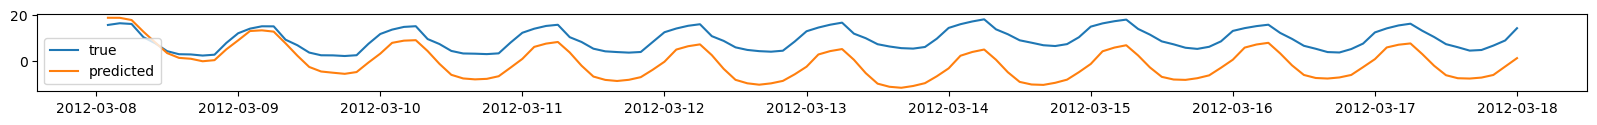

Correlation of the SARIMA model: 0.7416606078464256
RMSE of the SARIMA model: 11.327188953790882




08/01/2025 17:03:11 Iteration 26/40
2012-04-22 20:00:00 2012-05-02 20:00:00
Preprocessing train set...


  7%|▋         | 7/100 [00:49<10:54,  7.04s/it]


Preprocessing test set...


  7%|▋         | 7/100 [00:49<11:03,  7.13s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9497      0.001   1922.283      0.000       1.948       1.952
ar.L2         -0.9846      0.001   -952.189      0.000      -0.987      -0.983
ma.L1         -0.8582      0.002   -406.093      0.000      -0.862      -0.854
ma.L2          0.4250      0.002    174.527      0.000       0.420       0.430
ar.S.L12       1.5441      0.011    145.404      0.000       1.523       1.565
ar.S.L24      -0.6772      0.009    -72.790      0.000      -0.695      -0.659
ma.S.L12      -0.2951      0.012    -24.459      0.000      -0.319      -0.271
ma.S.L24       0.0433      0.009      4.615      0.000       0.025       0.062
sigma2         0.0189   7.55e-05    249.895      0.000       0.019       0.019
Sarima estimation converged? :True


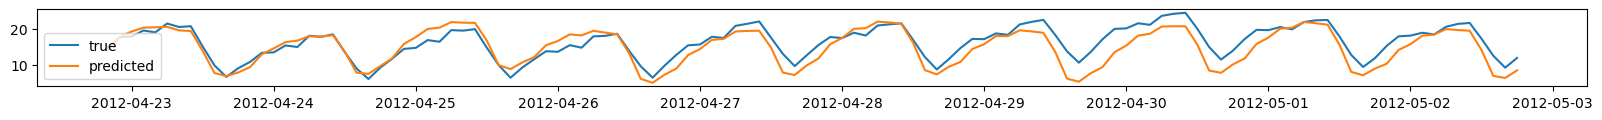

Correlation of the SARIMA model: 0.8695284080989025
RMSE of the SARIMA model: 2.7798539571031986




08/01/2025 17:07:52 Iteration 27/40
2012-07-14 06:00:00 2012-07-24 06:00:00
Preprocessing train set...


100%|██████████| 100/100 [10:15<00:00,  6.16s/it]


Preprocessing test set...


100%|██████████| 100/100 [10:13<00:00,  6.13s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9382      0.002   1278.870      0.000       1.935       1.941
ar.L2         -0.9799      0.002   -611.782      0.000      -0.983      -0.977
ma.L1         -0.7615      0.004   -172.050      0.000      -0.770      -0.753
ma.L2          0.4334      0.004    100.774      0.000       0.425       0.442
ar.S.L12       0.2884      0.029      9.938      0.000       0.232       0.345
ar.S.L24       0.3530      0.026     13.785      0.000       0.303       0.403
ma.S.L12       0.7199      0.029     24.687      0.000       0.663       0.777
ma.S.L24       0.2913      0.008     34.964      0.000       0.275       0.308
sigma2         0.0301      0.000    191.932      0.000       0.030       0.030
Sarima estimation converged? :True


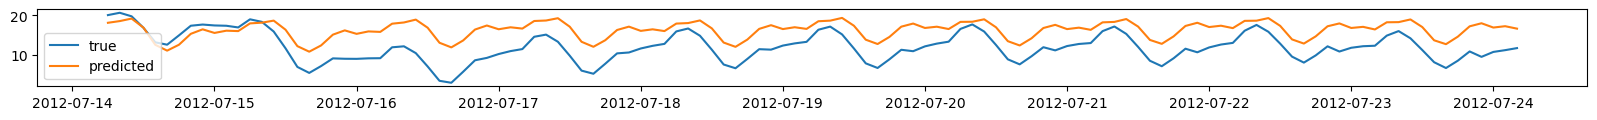

Correlation of the SARIMA model: 0.6969896979250285
RMSE of the SARIMA model: 5.119594322575996




08/01/2025 17:31:05 Iteration 28/40
2012-09-30 00:00:00 2012-10-10 00:00:00
Preprocessing train set...


100%|██████████| 100/100 [09:34<00:00,  5.74s/it]


Preprocessing test set...


100%|██████████| 100/100 [06:58<00:00,  4.19s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9409      0.001   1298.704      0.000       1.938       1.944
ar.L2         -0.9817      0.002   -624.493      0.000      -0.985      -0.979
ma.L1         -0.7580      0.004   -172.606      0.000      -0.767      -0.749
ma.L2          0.4283      0.004    100.010      0.000       0.420       0.437
ar.S.L12       0.0925      0.016      5.918      0.000       0.062       0.123
ar.S.L24       0.5235      0.015     34.419      0.000       0.494       0.553
ma.S.L12       0.8982      0.016     55.821      0.000       0.867       0.930
ma.S.L24       0.3309      0.007     48.410      0.000       0.318       0.344
sigma2         0.0302      0.000    190.747      0.000       0.030       0.031
Sarima estimation converged? :True


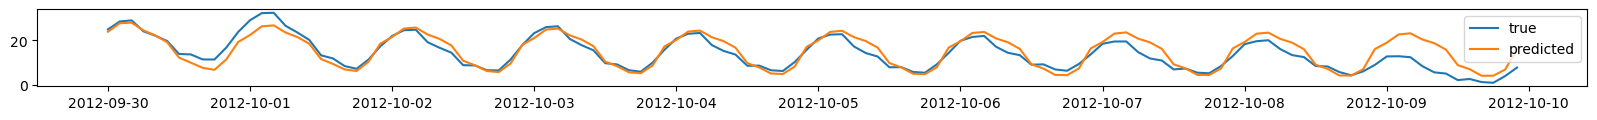

Correlation of the SARIMA model: 0.8770852271995151
RMSE of the SARIMA model: 3.7649814095064174




08/01/2025 17:49:41 Iteration 29/40
2012-10-07 06:00:00 2012-10-17 06:00:00
Preprocessing train set...


100%|██████████| 100/100 [07:16<00:00,  4.37s/it]


Preprocessing test set...


100%|██████████| 100/100 [07:04<00:00,  4.25s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9378      0.002   1181.921      0.000       1.935       1.941
ar.L2         -0.9788      0.002   -567.043      0.000      -0.982      -0.975
ma.L1         -0.7314      0.004   -164.528      0.000      -0.740      -0.723
ma.L2          0.4260      0.004     99.388      0.000       0.418       0.434
ar.S.L12       0.1093      0.015      7.089      0.000       0.079       0.139
ar.S.L24       0.5097      0.015     33.780      0.000       0.480       0.539
ma.S.L12       0.8428      0.016     52.991      0.000       0.812       0.874
ma.S.L24       0.3273      0.007     45.948      0.000       0.313       0.341
sigma2         0.0319      0.000    188.507      0.000       0.032       0.032
Sarima estimation converged? :True


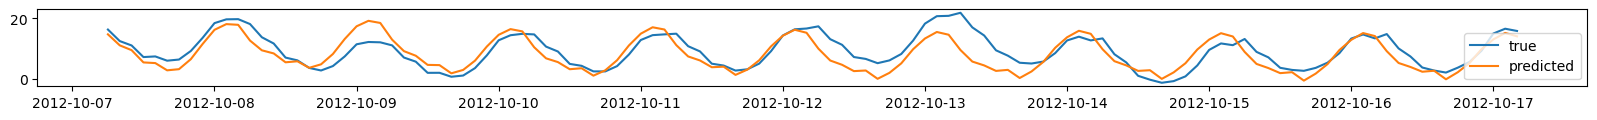

Correlation of the SARIMA model: 0.7902200992026356
RMSE of the SARIMA model: 3.617982825546178




08/01/2025 18:06:51 Iteration 30/40
2012-11-13 00:00:00 2012-11-23 00:00:00
Preprocessing train set...


100%|██████████| 100/100 [07:05<00:00,  4.25s/it]


Preprocessing test set...


100%|██████████| 100/100 [06:50<00:00,  4.10s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9322      0.002   1094.738      0.000       1.929       1.936
ar.L2         -0.9749      0.002   -513.457      0.000      -0.979      -0.971
ma.L1         -0.6465      0.005   -139.850      0.000      -0.656      -0.637
ma.L2          0.4026      0.004    100.651      0.000       0.395       0.410
ar.S.L12       0.4846      0.040     12.115      0.000       0.406       0.563
ar.S.L24       0.1956      0.033      5.918      0.000       0.131       0.260
ma.S.L12       0.4901      0.040     12.288      0.000       0.412       0.568
ma.S.L24       0.2327      0.009     26.154      0.000       0.215       0.250
sigma2         0.0325      0.000    196.675      0.000       0.032       0.033
Sarima estimation converged? :True


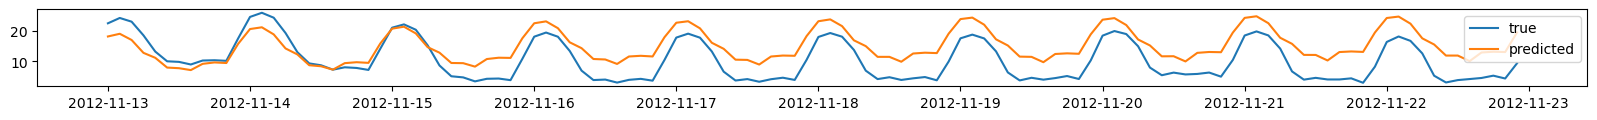

Correlation of the SARIMA model: 0.7796867116653952
RMSE of the SARIMA model: 6.126635173078587




08/01/2025 18:23:36 Iteration 31/40
2013-03-16 08:00:00 2013-03-26 08:00:00
Preprocessing train set...


  6%|▌         | 6/100 [00:30<07:51,  5.02s/it]


Preprocessing test set...


  6%|▌         | 6/100 [00:31<08:07,  5.18s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9307      0.002   1047.378      0.000       1.927       1.934
ar.L2         -0.9745      0.002   -495.293      0.000      -0.978      -0.971
ma.L1         -0.3811      0.004    -88.084      0.000      -0.390      -0.373
ma.L2          0.4027      0.003    122.324      0.000       0.396       0.409
ar.S.L12       1.7695      0.008    223.204      0.000       1.754       1.785
ar.S.L24      -0.8310      0.007   -125.118      0.000      -0.844      -0.818
ma.S.L12      -0.7768      0.009    -87.465      0.000      -0.794      -0.759
ma.S.L24       0.0728      0.009      8.343      0.000       0.056       0.090
sigma2         0.0181   8.75e-05    206.843      0.000       0.018       0.018
Sarima estimation converged? :True


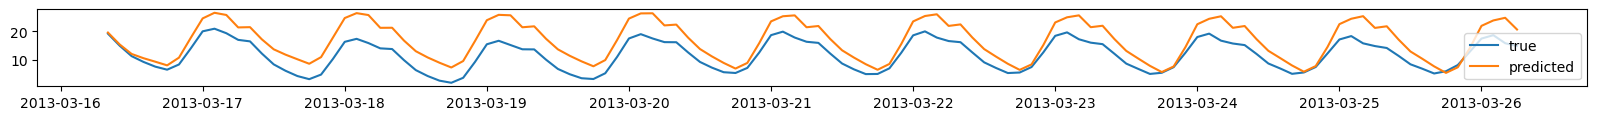

Correlation of the SARIMA model: 0.9410077185272743
RMSE of the SARIMA model: 5.482421237914584




08/01/2025 18:28:40 Iteration 32/40
2013-05-31 02:00:00 2013-06-10 02:00:00
Preprocessing train set...


100%|██████████| 100/100 [07:08<00:00,  4.29s/it]


Preprocessing test set...


100%|██████████| 100/100 [07:38<00:00,  4.58s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9349      0.001   1590.169      0.000       1.933       1.937
ar.L2         -0.9811      0.001   -736.122      0.000      -0.984      -0.978
ma.L1          0.8837      0.002    377.484      0.000       0.879       0.888
ma.L2         -0.1049      0.003    -40.835      0.000      -0.110      -0.100
ar.S.L12       0.5676      0.031     18.433      0.000       0.507       0.628
ar.S.L24       0.2376      0.029      8.172      0.000       0.181       0.295
ma.S.L12       0.4224      0.030     14.097      0.000       0.364       0.481
ma.S.L24       0.2557      0.007     34.199      0.000       0.241       0.270
sigma2         0.0083   3.56e-05    233.838      0.000       0.008       0.008
Sarima estimation converged? :False


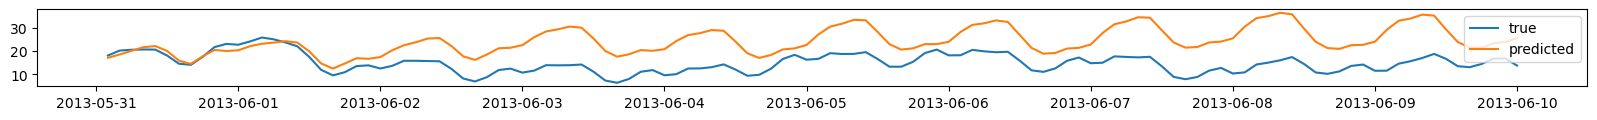

Correlation of the SARIMA model: 0.3021814031626614
RMSE of the SARIMA model: 11.024005021382179




08/01/2025 18:49:17 Iteration 33/40
2013-06-27 18:00:00 2013-07-07 18:00:00
Preprocessing train set...


100%|██████████| 100/100 [07:43<00:00,  4.64s/it]


Preprocessing test set...


100%|██████████| 100/100 [07:39<00:00,  4.60s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9380      0.001   1635.241      0.000       1.936       1.940
ar.L2         -0.9832      0.001   -759.687      0.000      -0.986      -0.981
ma.L1          0.8909      0.002    383.772      0.000       0.886       0.895
ma.L2         -0.0988      0.003    -38.691      0.000      -0.104      -0.094
ar.S.L12       0.4991      0.029     17.031      0.000       0.442       0.557
ar.S.L24       0.2897      0.028     10.422      0.000       0.235       0.344
ma.S.L12       0.4896      0.029     17.075      0.000       0.433       0.546
ma.S.L24       0.2660      0.007     37.834      0.000       0.252       0.280
sigma2         0.0083   3.57e-05    233.166      0.000       0.008       0.008
Sarima estimation converged? :True


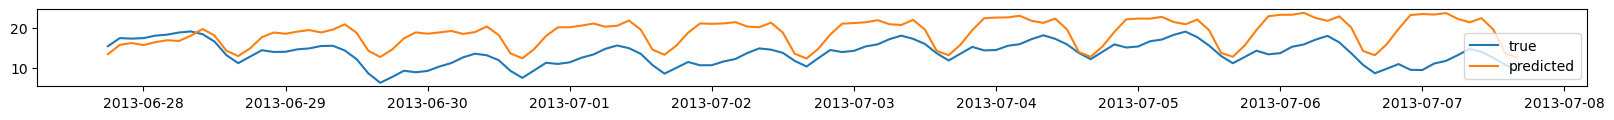

Correlation of the SARIMA model: 0.44132614431620504
RMSE of the SARIMA model: 6.131014203118756




08/01/2025 19:08:25 Iteration 34/40
2014-02-17 22:00:00 2014-02-27 22:00:00
Preprocessing train set...


  9%|▉         | 9/100 [00:47<07:58,  5.25s/it]


Preprocessing test set...


  9%|▉         | 9/100 [00:46<07:53,  5.20s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9388      0.002   1104.926      0.000       1.935       1.942
ar.L2         -0.9794      0.002   -556.032      0.000      -0.983      -0.976
ma.L1         -0.2419      0.006    -42.581      0.000      -0.253      -0.231
ma.L2          0.3123      0.002    137.273      0.000       0.308       0.317
ar.S.L12       0.5347      0.011     49.871      0.000       0.514       0.556
ar.S.L24       0.2543      0.010     26.394      0.000       0.235       0.273
ma.S.L12       0.4799      0.008     58.864      0.000       0.464       0.496
ma.S.L24       0.3816      0.004     94.811      0.000       0.374       0.389
sigma2         0.0178   8.72e-05    204.334      0.000       0.018       0.018
Sarima estimation converged? :True


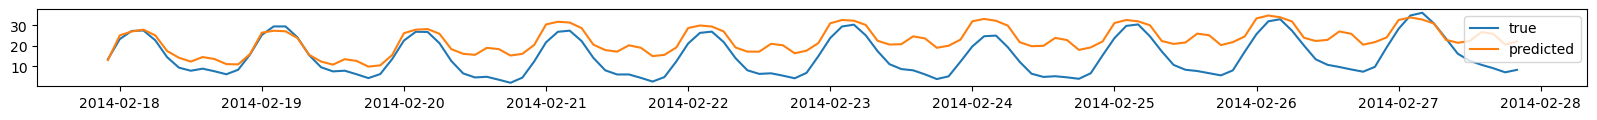

Correlation of the SARIMA model: 0.8081711383759254
RMSE of the SARIMA model: 9.570288520670243




08/01/2025 19:13:07 Iteration 35/40
2015-03-16 12:00:00 2015-03-26 12:00:00
Preprocessing train set...


 71%|███████   | 71/100 [05:31<02:15,  4.67s/it]


Preprocessing test set...


 81%|████████  | 81/100 [06:08<01:26,  4.55s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9422      0.001   1355.036      0.000       1.939       1.945
ar.L2         -0.9842      0.001   -681.874      0.000      -0.987      -0.981
ma.L1         -0.2901      0.006    -51.935      0.000      -0.301      -0.279
ma.L2          0.2803      0.003     96.567      0.000       0.275       0.286
ar.S.L12       0.1688      0.009     19.632      0.000       0.152       0.186
ar.S.L24       0.5873      0.009     64.444      0.000       0.569       0.605
ma.S.L12       1.0167      0.007    138.836      0.000       1.002       1.031
ma.S.L24       0.3878      0.003    154.950      0.000       0.383       0.393
sigma2         0.0168   8.46e-05    198.323      0.000       0.017       0.017
Sarima estimation converged? :True


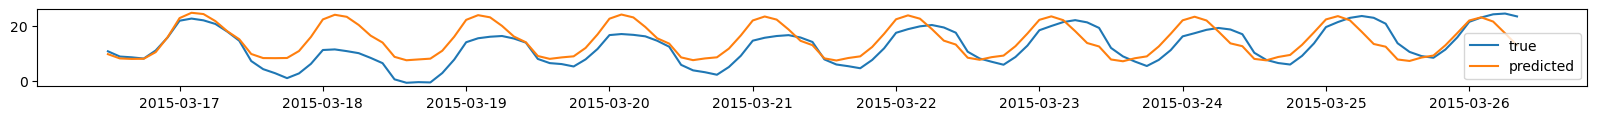

Correlation of the SARIMA model: 0.7241415499959832
RMSE of the SARIMA model: 5.181895500951603




08/01/2025 19:28:49 Iteration 36/40
2015-06-21 18:00:00 2015-07-01 18:00:00
Preprocessing train set...


 53%|█████▎    | 53/100 [04:30<04:00,  5.11s/it]


Preprocessing test set...


 62%|██████▏   | 62/100 [04:58<03:02,  4.81s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9345      0.002   1232.044      0.000       1.931       1.938
ar.L2         -0.9816      0.002   -622.901      0.000      -0.985      -0.979
ma.L1         -0.2109      0.005    -40.294      0.000      -0.221      -0.201
ma.L2          0.3329      0.002    154.233      0.000       0.329       0.337
ar.S.L12       1.8128      0.005    353.842      0.000       1.803       1.823
ar.S.L24      -0.8623      0.005   -186.576      0.000      -0.871      -0.853
ma.S.L12      -0.7712      0.007   -103.113      0.000      -0.786      -0.757
ma.S.L24       0.0241      0.007      3.435      0.001       0.010       0.038
sigma2         0.0167   9.21e-05    181.305      0.000       0.017       0.017
Sarima estimation converged? :False


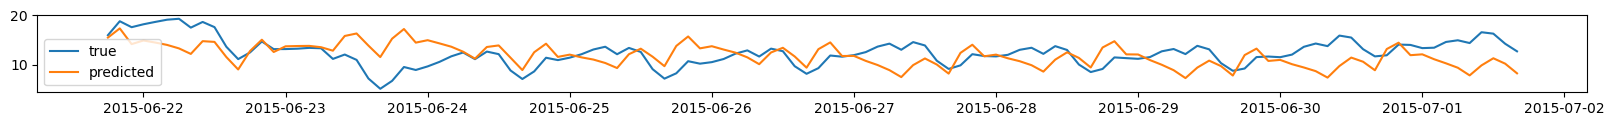

Correlation of the SARIMA model: 0.09057098375128514
RMSE of the SARIMA model: 3.3544939213127654




08/01/2025 19:42:39 Iteration 37/40
2015-10-06 14:00:00 2015-10-16 14:00:00
Preprocessing train set...


 48%|████▊     | 48/100 [04:15<04:36,  5.32s/it]


Preprocessing test set...


 46%|████▌     | 46/100 [04:05<04:48,  5.35s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9387      0.001   1666.211      0.000       1.936       1.941
ar.L2         -0.9793      0.001   -905.131      0.000      -0.981      -0.977
ma.L1         -0.2962      0.005    -59.106      0.000      -0.306      -0.286
ma.L2          0.3540      0.003    102.509      0.000       0.347       0.361
ar.S.L12       0.6627      0.010     65.027      0.000       0.643       0.683
ar.S.L24       0.1788      0.010     18.363      0.000       0.160       0.198
ma.S.L12       0.3804      0.011     35.754      0.000       0.360       0.401
ma.S.L24       0.3229      0.003    110.788      0.000       0.317       0.329
sigma2         0.0152   8.38e-05    181.649      0.000       0.015       0.015
Sarima estimation converged? :True


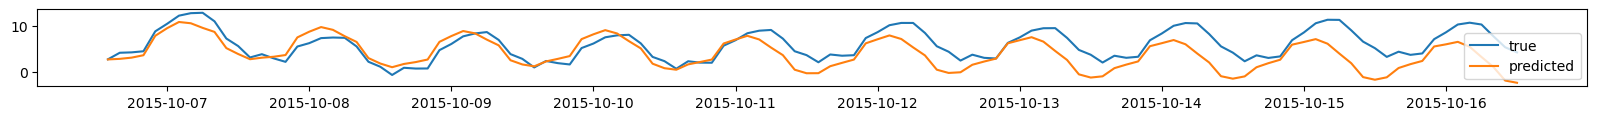

Correlation of the SARIMA model: 0.6809418427888702
RMSE of the SARIMA model: 3.1293579575538972




08/01/2025 19:55:05 Iteration 38/40
2015-12-19 12:00:00 2015-12-29 12:00:00
Preprocessing train set...


 23%|██▎       | 23/100 [02:06<07:02,  5.49s/it]


Preprocessing test set...


 21%|██        | 21/100 [02:00<07:34,  5.76s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9359      0.002   1116.376      0.000       1.933       1.939
ar.L2         -0.9810      0.002   -565.286      0.000      -0.984      -0.978
ma.L1          0.1765      0.006     28.584      0.000       0.164       0.189
ma.L2          0.3015      0.007     40.996      0.000       0.287       0.316
ar.S.L12       1.8208      0.007    249.413      0.000       1.806       1.835
ar.S.L24      -0.8700      0.007   -128.081      0.000      -0.883      -0.857
ma.S.L12      -0.8249      0.011    -77.984      0.000      -0.846      -0.804
ma.S.L24       0.2211      0.010     23.199      0.000       0.202       0.240
sigma2         0.0077   5.79e-05    132.726      0.000       0.008       0.008
Sarima estimation converged? :False


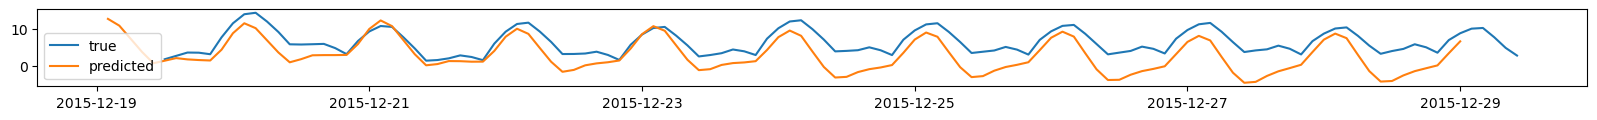

Correlation of the SARIMA model: -0.46821764372501695
RMSE of the SARIMA model: 7.42258903260737




08/01/2025 20:03:26 Iteration 39/40
2015-12-30 20:00:00 2016-01-09 20:00:00
Preprocessing train set...


 20%|██        | 20/100 [01:37<06:31,  4.89s/it]


Preprocessing test set...


 20%|██        | 20/100 [01:39<06:39,  4.99s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9367      0.002   1093.777      0.000       1.933       1.940
ar.L2         -0.9820      0.002   -555.532      0.000      -0.985      -0.979
ma.L1          0.2103      0.007     29.102      0.000       0.196       0.224
ma.L2          0.2898      0.008     34.739      0.000       0.273       0.306
ar.S.L12       1.8202      0.007    256.278      0.000       1.806       1.834
ar.S.L24      -0.8696      0.007   -131.617      0.000      -0.883      -0.857
ma.S.L12      -0.8122      0.011    -75.132      0.000      -0.833      -0.791
ma.S.L24       0.2171      0.010     21.764      0.000       0.198       0.237
sigma2         0.0075    6.7e-05    111.670      0.000       0.007       0.008
Sarima estimation converged? :False


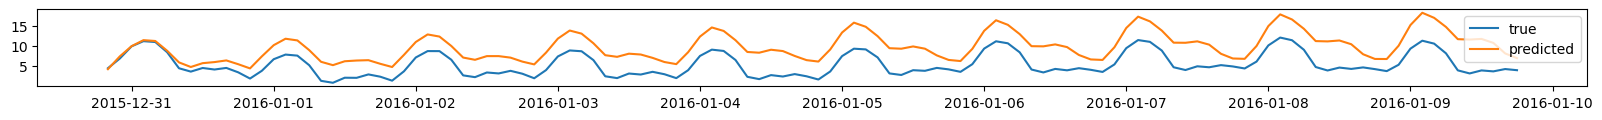

Correlation of the SARIMA model: 0.8520043535723238
RMSE of the SARIMA model: 4.690416247050326




08/01/2025 20:11:07 Iteration 40/40
2016-10-12 10:00:00 2016-10-22 10:00:00
Preprocessing train set...


  5%|▌         | 5/100 [00:30<09:36,  6.07s/it]


Preprocessing test set...


  5%|▌         | 5/100 [00:31<09:54,  6.25s/it]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9385      0.002   1142.588      0.000       1.935       1.942
ar.L2         -0.9899      0.002   -581.836      0.000      -0.993      -0.987
ma.L1          1.2630      0.008    159.659      0.000       1.247       1.278
ma.L2          0.2668      0.008     33.658      0.000       0.251       0.282
ar.S.L12       1.7936      0.011    169.575      0.000       1.773       1.814
ar.S.L24      -0.8409      0.010    -87.767      0.000      -0.860      -0.822
ma.S.L12      -0.7518      0.015    -51.127      0.000      -0.781      -0.723
ma.S.L24       0.0715      0.011      6.762      0.000       0.051       0.092
sigma2         0.0025   2.67e-05     94.146      0.000       0.002       0.003
Sarima estimation converged? :False


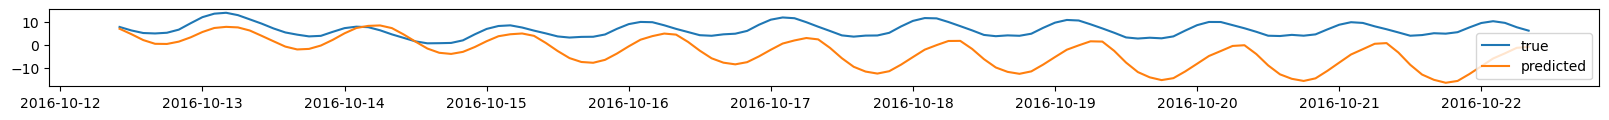

Correlation of the SARIMA model: 0.46517887501787986
RMSE of the SARIMA model: 11.40723520437789






In [22]:
### To be run on a GPU
results_lstm = {'predictions': [], 'correlation':[], 'rmse':[]}
results_seq2seq = {'predictions':[], 'correlation':[], 'rmse':[]}

for ix, (start, end) in enumerate(storms):
    # print(start, end)
    dt_t = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
    print('{} Iteration {}/{}'.format(dt_t, ix+1, len(storms)))
    print(start - timedelta(days=1), start + timedelta(days=9))
    
    ### Preprocess train and test
    train, test = get_train_and_test(train_start=start - timedelta(days=365*2+1), test_start=start - timedelta(days=1), test_end=start + timedelta(days=9))
    train2, test2 = get_train_and_test(train_start=start - timedelta(days=365*2+1), test_start=start - timedelta(days=10), test_end=start + timedelta(days=9))
    test2 = test2[len(test2) - len(test) - 50:]
    test2 = np.array(test2).reshape(-1, 1)
    
    ### LSTM
    num_lstm_layers = 2
    dropout_rate = 0.2
    batch_size = 48
    epochs = 500
    validation_split = 0.05
    input_dim = 1
    output_dim = 1
    
    train = np.array(train).reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_train = scaler.fit_transform(train)

    sequence_length = 50
    X_train, y_train = [], []

    for k in range(len(scaled_train) - sequence_length):
        X_train.append(scaled_train[k:k + sequence_length])
        y_train.append(scaled_train[k + sequence_length])

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    scaled_test = scaler.fit_transform(test2)

    X_test, y_test = [], []
    for k in range(len(scaled_test) - sequence_length):
        X_test.append(scaled_test[k:k + sequence_length])
        y_test.append(scaled_test[k + sequence_length])
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    model = Sequential()

    model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(sequence_length, input_dim)))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units=50, activation='relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(units=output_dim, activation='linear'))

    model.compile(optimizer='Adam', loss='mae', metrics=['mae'])

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        verbose=0
    )
    model.save(f'lstm/lstm_model_storm_{ix}.keras')

    lstm_unscaled_prediction = model.predict(X_test)
    lstm_predictions = scaler.inverse_transform(lstm_unscaled_prediction)

    unscaled_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    results_lstm['correlation'].append(pearsonr(unscaled_y_test.flatten(), lstm_predictions.flatten()).statistic)
    results_lstm['predictions'].append(lstm_predictions)
    results_lstm['rmse'].append(np.sqrt(np.mean((unscaled_y_test - lstm_predictions)**2)))


    ### Seq2Seq
    learning_rate = 0.01
    lambda_l2_reg = 0.003
    hidden_dim = 64
    num_lstm_layers = 1  
    gradient_clipping = 2.5
    num_input_signals = 1
    num_output_signals = 1

    model = Sequential()

    model.add(LSTM(
        units=hidden_dim, 
        activation='relu', 
        input_shape=(X_train.shape[1], num_input_signals), 
        return_sequences=False, 
        kernel_regularizer=tf.keras.regularizers.l2(lambda_l2_reg)
    ))

    model.add(Dense(units=num_output_signals))

    optimizer = Adam(learning_rate=learning_rate, clipvalue=gradient_clipping)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    model.summary()

    history = model.fit(
        X_train, y_train,
        epochs=1500,
        batch_size=48,
        validation_split=0.2,
        verbose=0,
    )
    model.save(f'seq2seq/seq2seq_storm_{ix}.keras')

    seq2seq_unscaled_prediction = model.predict(X_test)
    seq2seq_predictions = scaler.inverse_transform(seq2seq_unscaled_prediction)

    results_seq2seq['correlation'].append(pearsonr(unscaled_y_test.flatten(), seq2seq_predictions.flatten()).statistic)
    results_seq2seq['predictions'].append(seq2seq_predictions)
    results_seq2seq['rmse'].append(np.sqrt(np.mean((unscaled_y_test - seq2seq_predictions)**2)))

    with open('results.txt', 'w') as file:
        file.write('='*100)
        file.write('\n')
        file.write('LSTM\n')
        file.write('='*100)
        file.write('\n')
        for key, value in results_lstm.items():
            file.write(f"{key}: {value}\n")
        file.write('\n\n\n')
        file.write('='*100)
        file.write('\n')
        file.write('Seq2Seq\n')
        file.write('='*100)
        file.write('\n')
        for key, value in results_seq2seq.items():
            file.write(f"{key}: {value}\n")

    print('\n\n\n')